## Process Data from Sept Cruise (Sept 4-9) for Analysis

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

import hvplot.xarray


import cartopy.crs as crs

import pandas as pd
import glob
import hvplot.pandas  # noqa
from datetime import timedelta
from datetime import datetime
from matplotlib.patches import Ellipse

#### Pull in CDOM data and ship TSG/GPS data

CDOM data here is from the fCDOM recorded using a DataQ

In [5]:
path = 'data/sept_cruise/wscd859/' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df_tmp = pd.read_csv(filename, index_col=None, header=1)
    li.append(df_tmp)
cdom_df = pd.concat(li, axis=0, ignore_index=True)

cdom_df['utc_dt'] = pd.to_datetime(cdom_df['yyyy/mm/dd HH:MM:SS.fff'])

cdom_df = cdom_df.set_index('utc_dt')

In [6]:
# need to remove duplicates to match up to tsg data
cdom_df = cdom_df.loc[~cdom_df.index.duplicated(keep='first')]
cdom_df = cdom_df.sort_index(ascending=True)

This navigation and TSG data is from the R/V Shearwater's nav system and the Seabird TSG on the flow through

In [7]:
nav_df = pd.read_csv('data/sept_cruise/SW21011R_RFP/Navigation/SW-GGA_20210904-222337.Raw',  names=['Date', 'Time', 'GPGGA','Unknown', 'SW-GGA-Lat', 'latdir', 'SW-GGA-Long', 'londir', '1', '2', '3', '4', '5', '6', '7'])

def dms2dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes/60 + seconds/(60*60);
    if direction == 'W' or direction == 'S':
        dd *= -1
    return dd;

nav_df['lon'] = dms2dd(pd.to_numeric(nav_df['SW-GGA-Long'].astype(str).str[:2]).astype(float), pd.to_numeric(nav_df['SW-GGA-Long'].astype(str).str[2:]),np.array(0), 'W')
nav_df['lat'] = dms2dd(pd.to_numeric(nav_df['SW-GGA-Lat'].astype(str).str[:2]).astype(float), pd.to_numeric(nav_df['SW-GGA-Lat'].astype(str).str[2:]),np.array(0), 'E')

In [8]:
date_time_strs = nav_df['Date'] + ' ' + nav_df['Time']

nav_df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M:%S.%f') for x in date_time_strs]
nav_df['utc_dt'] = nav_df['datetime']
nav_df  = nav_df.set_index('utc_dt')
tsg_df = pd.read_csv('data/sept_cruise/SW21011R_RFP/TSG/TSG-_20210904-222337.Raw', names=['DateTime', 'Temp','Sal','Unknown'], delim_whitespace=True)#sep=r"s*")# names=['Date', 'Time', 'Data'])
tsg_df
tsg_df['datetime'] = [datetime.strptime(x[:-1], '%m/%d/%Y,%H:%M:%S.%f') for x in tsg_df.DateTime]

lats = []
lons = []
for i in range(len(tsg_df)):
    row = nav_df.iloc[nav_df.index.get_loc(tsg_df.iloc[i].datetime, method='nearest')]
    lats.append(row.lat)
    lons.append(row.lon)
tsg_df['lat'] = lats
tsg_df['lon'] = lons

In [9]:
tsg_df['utc_dt'] = tsg_df['datetime']
tsg_df  = tsg_df.set_index('utc_dt')

In [10]:
tsg_df = tsg_df.sort_index(ascending=True)

In [11]:
# tsg_df = tsg_df.drop('DateTime', 1)

In [12]:
# tsg_df = tsg_df.drop('Unknown', 1)
# tsg_df.to_csv('sept_4_9_ship_data_geolocated.csv')

In [13]:
# tsg_df = pd.read_csv('sept_4_9_ship_data_geolocated.csv')

<AxesSubplot:>

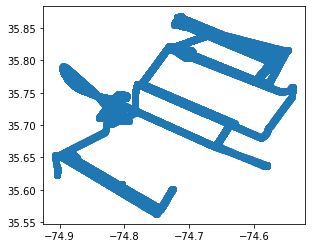

In [14]:
import geopandas as gpd

tsg_gdf = gpd.GeoDataFrame(
    tsg_df, geometry=gpd.points_from_xy(tsg_df.lon, tsg_df.lat))
tsg_gdf.loc['2021-09-5 11:00:00':'2021-09-8 20:45:00'].plot()

### Pull in FCM Data

Updated FCM data from June 2022

In [15]:
fcm_update_df = pd.read_csv('data/sept_cruise/SWPhytoplankton_combined_DEH 21June22_edited.csv')

In [16]:
fcm_df = pd.read_csv('data/sept_cruise/SW_fcm_full_bac_chla.csv')

In [17]:
# this is a stupid way to do this but I don't know a more efficient way without doing it manually

In [18]:
SynA = []
SynB = []
PicocyanoA = []
PicocyanoB = []
PicoeukA = []
PicoeukB = []
DetritusA = []
DetritusB = []

SynredfluA = []
SynredfluB = []
SynorangefluA = []
SynorangefluB = []
PicoredfluA = []
PicoredfluB = []
PicoeukredfluA = []
PicoeukredfluB = []



for row in fcm_update_df.itertuples(index=False):
    if 'A' in row.SAMPLE_ID:
        SynA.append(row.Syn_cells_mL_1)
        PicocyanoA.append(row.PicoCyano_cells_mL_1)
        PicoeukA.append(row.PicoEuk_cells_mL_1)
        DetritusA.append(row.Detritus_Count)
        SynredfluA.append(row.Syn_red_flu)
        SynorangefluA.append(row.Syn_orange_flu)
        PicoredfluA.append(row.picocyanos_red_flu)
        PicoeukredfluA.append(row.Peuks_red_flu)
    elif 'B' in row.SAMPLE_ID:
        SynB.append(row.Syn_cells_mL_1)
        PicocyanoB.append(row.PicoCyano_cells_mL_1)
        PicoeukB.append(row.PicoEuk_cells_mL_1)
        DetritusB.append(row.Detritus_Count)
        SynredfluB.append(row.Syn_red_flu)
        SynorangefluB.append(row.Syn_orange_flu)
        PicoredfluB.append(row.picocyanos_red_flu)
        PicoeukredfluB.append(row.Peuks_red_flu)

fcm_df['SynA'] = SynA
fcm_df['SynB'] = SynB
fcm_df['PicoCyanoA'] = PicocyanoA
fcm_df['PicoCyanoB'] = PicocyanoB
fcm_df['PeuksA'] = PicoeukA
fcm_df['PeaksB'] = PicoeukB
fcm_df['DetritusA'] = DetritusA
fcm_df['DetritusB'] = DetritusB

fcm_df['SynredfluA'] = SynredfluA
fcm_df['SynredfluB'] = SynredfluB
fcm_df['SynorangefluA'] = SynorangefluA
fcm_df['SynorangefluB'] = SynorangefluB
fcm_df['PicoredfluA'] = PicoredfluA
fcm_df['PicoredfluB'] = PicoredfluB
fcm_df['PicoeukredfluA'] = PicoeukredfluA
fcm_df['PicoeukredfluB'] = PicoeukredfluB

In [19]:
fcm_df['Chla_Avg'][fcm_df['Chla_Avg']==-999]=np.nan

<ipython-input-19-a5003a0a14a8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcm_df['Chla_Avg'][fcm_df['Chla_Avg']==-999]=np.nan


In [20]:
fcm_df['Bacteria_A'][fcm_df['Bacteria_A']==-999]=np.nan
fcm_df['Bacteria_B'][fcm_df['Bacteria_B']==-999]=np.nan

<ipython-input-20-21214e81176b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcm_df['Bacteria_A'][fcm_df['Bacteria_A']==-999]=np.nan
<ipython-input-20-21214e81176b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fcm_df['Bacteria_B'][fcm_df['Bacteria_B']==-999]=np.nan


In [21]:
date_time_strs = fcm_df['Date'] + ' ' + fcm_df['Time (UTC)']
fcm_df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M') for x in date_time_strs]

In [22]:
fcm_df['utc_dt'] = fcm_df['datetime']
fcm_df  = fcm_df.set_index('utc_dt')

In [23]:
fcm_df = fcm_df.sort_index(ascending=True)

In [24]:
# lats = []
# lons = []
# for i in range(len(fcm_df)):
#     row = df.iloc[df.index.get_loc(pd.to_datetime(fcm_df.iloc[i].datetime), method='nearest')]
#     lats.append(row.lat)
#     lons.append(row.lon)
# fcm_df['lat'] = lats
# fcm_df['lon'] = lons

In [25]:
fcm_df.columns

Index(['Sample#', 'Time (UTC)', 'Date', 'Syn/mL', 'SynA', 'SynB', 'Syn_Avg',
       'Peuks/mL', 'PeuksA', 'PeaksB', 'Peuks_Avg', 'PicoCyano/mL',
       'PicoCyanoA', 'PicoCyanoB', 'PicoCyano_Avg', 'Bacteria_A', 'Bacteria_B',
       'Chla A', 'Chla B', 'Chla_Avg', 'DetritusA', 'DetritusB', 'SynredfluA',
       'SynredfluB', 'SynorangefluA', 'SynorangefluB', 'PicoredfluA',
       'PicoredfluB', 'PicoeukredfluA', 'PicoeukredfluB', 'datetime'],
      dtype='object')

## Pull in NCP Data

In [60]:
import scipy.io
fn = 'data/sept_cruise/SW_data.mat'
mat = scipy.io.loadmat(fn)
for item in list(mat.keys()):
    if item not in ['__header__', '__version__', '__globals__']:
        print(item)
        df_ncp = pd.DataFrame(data=mat[item], columns=['time', 'MLD', 'NCP mmol C m-2 d-1', 'NCP (mmol C m-3 d-1)'])
        
df_ncp['dt'] = pd.to_datetime(df_ncp.time-719529, unit='D')
df_ncp = df_ncp.set_index('dt')
df_ncp = df_ncp.sort_index(ascending=True)
df_ncp['datetime'] = pd.to_datetime(df_ncp.time-719529, unit='D')

SW_data


In [61]:
df_ncp.head()

time  MLD  NCP mmol C m-2 d-1  \
dt                                                                      
2021-09-04 22:58:00.000000512  738403.956944  NaN                 NaN   
2021-09-04 23:00:00.000003328  738403.958333  NaN                 NaN   
2021-09-04 23:02:00.000006144  738403.959722  NaN                 NaN   
2021-09-04 23:03:59.999999232  738403.961111  NaN                 NaN   
2021-09-04 23:06:00.000012032  738403.962500  NaN                 NaN   

                               NCP (mmol C m-3 d-1)  \
dt                                                    
2021-09-04 22:58:00.000000512                   NaN   
2021-09-04 23:00:00.000003328                   NaN   
2021-09-04 23:02:00.000006144                   NaN   
2021-09-04 23:03:59.999999232                   NaN   
2021-09-04 23:06:00.000012032                   NaN   

                                                   datetime  
dt                                                           
2021-09-04 22:58:00.000000512 2021-09-04 22:58:00.000000512  
2021-09-04 23:00:00.000003328 2021-09-04 23:00:00.000003328  
2021-09-04 23:02:00.000006144 2021-09-04 23:02:00.000006144  
2021-09-04 23:03:59.999999232 2021-09-04 23:03:59.999999232  
2021-09-04 23:06:00.000012032 2021-09-04 23:06:00.000012032

In [62]:
df_new_ncp = pd.read_csv('data/sept_cruise/NCP_AKN_08162022.csv')

df_new_ncp['dt'] = pd.to_datetime(df_new_ncp['Matlab Serial Date Number']-719529, unit='D')
df_new_ncp = df_new_ncp.set_index('dt')
df_new_ncp = df_new_ncp.sort_index(ascending=True)
df_new_ncp['datetime'] = pd.to_datetime(df_new_ncp['Matlab Serial Date Number']-719529, unit='D')

In [63]:
df_ncp['updated_ncp_m2'] = df_new_ncp['NCP (mmol C/m2d)'].values

In [64]:
fn = 'data/sept_cruise/new_data_AKN.mat'
mat = scipy.io.loadmat(fn)
for item in list(mat.keys()):
    if item not in ['__header__', '__version__', '__globals__']:
        print(item)
        df_ncp_final = pd.DataFrame(data=mat[item], columns=['time', 'NCP mmol O2 m-2 d-1'])
        
df_ncp_final['dt'] = pd.to_datetime(df_ncp_final.time-719529, unit='D')
df_ncp_final = df_ncp_final.set_index('dt')
df_ncp_final = df_ncp_final.sort_index(ascending=True)
df_ncp_final['datetime'] = pd.to_datetime(df_ncp_final.time-719529, unit='D')

new_data_AKN


In [65]:
df_ncp['updated_ncp_m2'] = df_ncp_final['NCP mmol O2 m-2 d-1'].values

In [66]:
Ts = []
Ss = []

for i in range(len(df_ncp)):
    idx = tsg_df.index[tsg_df.index.get_loc(pd.to_datetime(df_ncp.iloc[i].datetime), method='nearest')]
    
    Ts.append(tsg_df.loc[idx].Temp)
    Ss.append(tsg_df.loc[idx].Sal)

df_ncp['temp'] = Ts
df_ncp['sal'] = Ss

<AxesSubplot:xlabel='dt'>

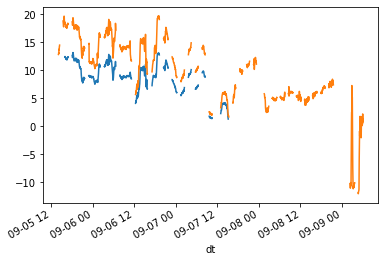

In [67]:
df_ncp['NCP mmol C m-2 d-1'].plot()
# df_new_ncp['NCP (mmol C/m2d)'].plot()
df_ncp['updated_ncp_m2'].plot()



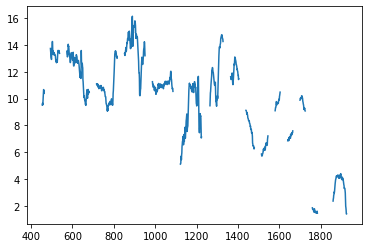

In [68]:
plt.plot(range(len(df_new_ncp['NCP (mmol C/m2d)'])),df_new_ncp['NCP (mmol C/m2d)'])

#### Pull in Nutrient Data

In [26]:
nuts_df = pd.read_csv('data/sept_cruise/20220131_nutstoUCSD_data.csv')

date_time_strs = nuts_df['Date'] + ' ' + nuts_df['Time (UTC)']
nuts_df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M') for x in date_time_strs]
nuts_df['utc_dt'] = nuts_df['datetime']
nuts_df  = nuts_df.set_index('utc_dt')
nuts_df = nuts_df.sort_index(ascending=True)
nuts_df.head()

Station  NO3a  PO4a  SILa  NO2a  NH4a  NO3b  PO4b  SILb  \
utc_dt                                                                         
2021-09-05 12:07:00        1  0.11  0.06   0.8  0.00  0.25  0.10  0.08   1.1   
2021-09-05 13:02:00        2  0.26  0.06   1.5  0.01  0.35  0.23  0.08   2.3   
2021-09-05 13:48:00        3  0.27  0.06   2.3  0.01  0.25  0.32  0.08   2.6   
2021-09-05 14:08:00        4  0.15  0.06   2.3  0.01  0.15  0.18  0.06   1.5   
2021-09-05 14:24:00        6  0.06  0.04   1.0  0.01  0.16  0.10  0.07   1.0   

                     NO2b  NH4b Time (UTC)      Date            datetime  
utc_dt                                                                    
2021-09-05 12:07:00  0.00  0.18      12:07  9/5/2021 2021-09-05 12:07:00  
2021-09-05 13:02:00  0.01  0.23      13:02  9/5/2021 2021-09-05 13:02:00  
2021-09-05 13:48:00  0.01  0.22      13:48  9/5/2021 2021-09-05 13:48:00  
2021-09-05 14:08:00  0.01  0.30      14:08  9/5/2021 2021-09-05 14:08:00  
2021-09-05 14:24:00  0.01  0.21      14:24  9/5/2021 2021-09-05 14:24:00

### Match up all the data in time

In [70]:
SynAs = []
PeuksAs = []
PicoCyanoAs = [] 
SynBs = []
PeuksBs = []
PicoCyanoBs = [] 
BacteriaAs = []
BacteriaBs = []
ChlaAvgs = []
ChlaAs = []
ChlaBs = []
sample_nums = []

DetritusA = []
DetritusB = []
SynredfluA = []
SynredfluB = []
SynorangefluA = []
SynorangefluB = []
PicoredfluA = []
PicoredfluB = []
PicoeukredfluA = []
PicoeukredfluB = []

NO3as = []
PO4as = []
SILas = []
NO2as = []
NH4as = []
NO3bs = []
PO4bs = []
SILbs = []
NO2bs = []
NH4bs = []

cdomVolts = []

ncp_area = []
ncp_vol = []
mld_list = []

for i in range(len(tsg_df)):
    try:
        row = fcm_df.iloc[fcm_df.index.get_loc(pd.to_datetime(tsg_df.iloc[i].datetime), method='nearest', tolerance=pd.Timedelta('5sec'))]
        SynAs.append(row.SynA)
        PeuksAs.append(row.PeuksA) 
        PicoCyanoAs.append(row.PicoCyanoA)
        SynBs.append(row.SynB)
        PeuksBs.append(row.PeaksB) 
        PicoCyanoBs.append(row.PicoCyanoB)
        BacteriaAs.append(row.Bacteria_A)
        BacteriaBs.append(row.Bacteria_B)
        ChlaAvgs.append(row.Chla_Avg)
        ChlaAs.append(row['Chla A'])
        ChlaBs.append(row['Chla B'])
        sample_nums.append(row['Sample#'])

        
        DetritusA.append(row.DetritusA)
        SynredfluA.append(row.SynredfluA)
        SynorangefluA.append(row.SynorangefluA)
        PicoredfluA.append(row.PicoredfluA)
        PicoeukredfluA.append(row.PicoeukredfluA)
        
        DetritusB.append(row.DetritusB)
        SynredfluB.append(row.SynredfluB)
        SynorangefluB.append(row.SynorangefluB)
        PicoredfluB.append(row.PicoredfluB)
        PicoeukredfluB.append(row.PicoeukredfluB)
        
    except KeyError:
        SynAs.append(np.nan)
        PeuksAs.append(np.nan) 
        PicoCyanoAs.append(np.nan)
        SynBs.append(np.nan)
        PeuksBs.append(np.nan) 
        PicoCyanoBs.append(np.nan)
        BacteriaAs.append(np.nan)
        BacteriaBs.append(np.nan)
        ChlaAvgs.append(np.nan)
        ChlaAs.append(np.nan)
        ChlaBs.append(np.nan)
        sample_nums.append(np.nan)
        
        
        DetritusA.append(np.nan)
        SynredfluA.append(np.nan)
        SynorangefluA.append(np.nan)
        PicoredfluA.append(np.nan)
        PicoeukredfluA.append(np.nan)
        
        DetritusB.append(np.nan)
        SynredfluB.append(np.nan)
        SynorangefluB.append(np.nan)
        PicoredfluB.append(np.nan)
        PicoeukredfluB.append(np.nan)
        
    try:
        row = cdom_df.iloc[cdom_df.index.get_loc(pd.to_datetime(tsg_df.iloc[i].datetime), method='nearest', tolerance=pd.Timedelta('5sec'))]
        cdomVolts.append(row[' V'])

    except KeyError:
        cdomVolts.append(np.nan)
        
    try:
        row = df_ncp.iloc[df_ncp.index.get_loc(pd.to_datetime(tsg_df.iloc[i].datetime), method='nearest', tolerance=pd.Timedelta('5sec'))]
        ncp_area.append(row['updated_ncp_m2'])
        ncp_vol.append(row['updated_ncp_m3'])
        mld_list.append(row['MLD'])

    except KeyError:
        ncp_area.append(np.nan)
        ncp_vol.append(np.nan)
        mld_list.append(np.nan)
        
    try:
        row = nuts_df.iloc[nuts_df.index.get_loc(pd.to_datetime(tsg_df.iloc[i].datetime), method='nearest', tolerance=pd.Timedelta('5sec'))]
        
        NO3as.append(row.NO3a)
        PO4as.append(row.PO4a)
        SILas.append(row.SILa) 
        NO2as.append(row.NO2a)
        NH4as.append(row.NH4a)
        NO3bs.append(row.NO3b)
        PO4bs.append(row.PO4b)
        SILbs.append(row.SILb)
        NO2bs.append(row.NO2b)
        NH4bs.append(row.NH4b)

    except KeyError:
        NO3as.append(np.nan)
        PO4as.append(np.nan)
        SILas.append(np.nan) 
        NO2as.append(np.nan)
        NH4as.append(np.nan)
        NO3bs.append(np.nan)
        PO4bs.append(np.nan)
        SILbs.append(np.nan)
        NO2bs.append(np.nan)
        NH4bs.append(np.nan)   
    
    if i % 2000 == 0:
        print(i)
        
tsg_df['SynA'] = SynAs
tsg_df['PeuksA'] = PeuksAs
tsg_df['PicoCyanoA'] = PicoCyanoAs
tsg_df['SynB'] = SynBs
tsg_df['PeuksB'] = PeuksBs
tsg_df['PicoCyanoB'] = PicoCyanoBs
tsg_df['BacteriaA'] = BacteriaAs
tsg_df['BacteriaB'] = BacteriaBs
tsg_df['ChlaAvg'] = ChlaAvgs
tsg_df['ChlaA'] = ChlaAs
tsg_df['ChlaB'] = ChlaBs
tsg_df['Sample#'] = sample_nums
tsg_df['cdomVolts'] = cdomVolts
# tsg_df['NCPm2'] = ncp_area
# tsg_df['NCPm3'] = ncp_vol
tsg_df['MLD'] = mld_list

tsg_df['DetritusA'] = DetritusA
tsg_df['DetritusB'] = DetritusB
tsg_df['SynredfluA'] = SynredfluA
tsg_df['SynredfluB'] = SynredfluB
tsg_df['SynorangefluA'] = SynorangefluA
tsg_df['SynorangefluB'] = SynorangefluB
tsg_df['PicoredfluA'] = PicoredfluA
tsg_df['PicoredfluB'] = PicoredfluB
tsg_df['PicoeukredfluA'] = PicoeukredfluA
tsg_df['PicoeukredfluB'] = PicoeukredfluB

tsg_df['NO3a'] = NO3as
tsg_df['PO4a'] = PO4as
tsg_df['SILa'] = SILas
tsg_df['NO2a'] = NO2as
tsg_df['NH4a'] = NH4as
tsg_df['NO3b'] = NO3bs
tsg_df['PO4b'] = PO4bs
tsg_df['SILb'] = SILbs
tsg_df['NO2b'] = NO2bs
tsg_df['NH4b'] = NH4bs

0
2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000
34000
36000
38000


ValueError: Length of values (42530) does not match length of index (39259)

In [72]:
tsg_df['ChlaA'][tsg_df['ChlaA']==-999]=np.nan
tsg_df['ChlaB'][tsg_df['ChlaB']==-999]=np.nan

<ipython-input-72-5bfe795cc01c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsg_df['ChlaA'][tsg_df['ChlaA']==-999]=np.nan
<ipython-input-72-5bfe795cc01c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tsg_df['ChlaB'][tsg_df['ChlaB']==-999]=np.nan


### Pull in Optical Data

This data could be merged but already has S and T and CDOM integrated and thus probably doesn't need to be merged with everything else

In [74]:
optical_df = pd.read_csv('data/optical_inline/linear_interp_210905-7_ACS_qc24.csv')
optical_df['datetime'] = pd.to_datetime(optical_df.dt)
optical_df['utc_dt'] = optical_df['datetime']
optical_df  = optical_df.set_index('utc_dt')
optical_df = optical_df.sort_index(ascending=True)

In [76]:
bb3_df = pd.read_csv('data/optical_inline/linear_interp_210905-7_BB3_qc24.csv')
bb3_df['datetime'] = pd.to_datetime(bb3_df.dt)
bb3_df['utc_dt'] = bb3_df['datetime']
bb3_df  = bb3_df.set_index('utc_dt')
bb3_df = bb3_df.sort_index(ascending=True)

In [77]:
tsg_optical_df = pd.read_csv('data/optical_inline/linear_interp_210905-7_TSG_qc24.csv')
tsg_optical_df['datetime'] = pd.to_datetime(tsg_optical_df.dt)
tsg_optical_df['utc_dt'] = tsg_optical_df['datetime']
tsg_optical_df  = tsg_optical_df.set_index('utc_dt')
tsg_optical_df = tsg_optical_df.sort_index(ascending=True)

In [78]:
tsg_optical_df.head(1)

dt        lat  lat_avg_sd  lat_avg_n        lon  \
utc_dt                                                                         
2021-09-05  2021/09/05 00:00:00  34.440118    0.000256          3 -34.440118   

            lon_avg_sd  lon_avg_n          t  t_avg_sd  t_avg_n  c  c_avg_sd  \
utc_dt                                                                         
2021-09-05    0.000256          3  26.668667  0.006898        3  0         0   

            c_avg_n        s  s_avg_sd  s_avg_n  sigma  sigma_avg_sd  \
utc_dt                                                                 
2021-09-05        3  35.9338    0.0025        3      0             0   

            sigma_avg_n   datetime  
utc_dt                              
2021-09-05            3 2021-09-05

In [79]:
cdom_optical_df = pd.read_csv('data/optical_inline/linear_interp_210905-7_CDOM_qc24.csv')
cdom_optical_df['datetime'] = pd.to_datetime(cdom_optical_df.dt)
cdom_optical_df['utc_dt'] = cdom_optical_df['datetime']
cdom_optical_df  = cdom_optical_df.set_index('utc_dt')
cdom_optical_df = cdom_optical_df.sort_index(ascending=True)

In [81]:
bb1s = []
bb2s = []
bb3s = []

Ts = []
Ss = []
CDOMs = []

for i in range(len(optical_df)):
    idx = bb3_df.index[bb3_df.index.get_loc(pd.to_datetime(optical_df.iloc[i].datetime), method='nearest')]
    bb1s.append(bb3_df.loc[idx].bbp_1)
    bb2s.append(bb3_df.loc[idx].bbp_2)
    bb3s.append(bb3_df.loc[idx].bbp_3)
    
    idx = tsg_optical_df.index[tsg_optical_df.index.get_loc(pd.to_datetime(optical_df.iloc[i].datetime), method='nearest')]
    Ts.append(tsg_optical_df.loc[idx].t)
    Ss.append(tsg_optical_df.loc[idx].s)
    
    idx = cdom_optical_df.index[cdom_optical_df.index.get_loc(pd.to_datetime(optical_df.iloc[i].datetime), method='nearest')]
    CDOMs.append(cdom_optical_df.loc[idx].fdom)
    
optical_df['bbp1'] = bb1s
optical_df['bbp2'] = bb2s
optical_df['bbp3'] = bb3s
optical_df['temp'] = Ts
optical_df['sal'] = Ss
optical_df['cdom'] = CDOMs

    
    

In [83]:
optical_df['bbp_ratio_440'] = optical_df.bbp1/(optical_df.iloc[:, 8+81:12+81].mean(axis=1) - optical_df.iloc[:, 8:12].mean(axis=1))
optical_df['bbp_ratio_440']

utc_dt
2021-09-05 12:26:00         NaN
2021-09-05 12:28:00         NaN
2021-09-05 12:30:00         NaN
2021-09-05 12:32:00         NaN
2021-09-05 12:34:00         NaN
                         ...   
2021-09-07 22:40:00    0.003074
2021-09-07 22:42:00    0.004491
2021-09-07 22:44:00    0.005081
2021-09-07 22:46:00    0.003738
2021-09-07 22:48:00    0.004551
Name: bbp_ratio_440, Length: 1592, dtype: float64

In [84]:
optical_df['bbp_ratio_532'] = optical_df.bbp2/(optical_df.iloc[:, 29+81:31+81].mean(axis=1) - optical_df.iloc[:, 29:31].mean(axis=1))
optical_df['bbp_ratio_532']

utc_dt
2021-09-05 12:26:00         NaN
2021-09-05 12:28:00         NaN
2021-09-05 12:30:00         NaN
2021-09-05 12:32:00         NaN
2021-09-05 12:34:00         NaN
                         ...   
2021-09-07 22:40:00    0.000798
2021-09-07 22:42:00    0.001293
2021-09-07 22:44:00    0.001998
2021-09-07 22:46:00    0.001984
2021-09-07 22:48:00    0.002143
Name: bbp_ratio_532, Length: 1592, dtype: float64

In [85]:
lats = []
lons = []

for i in range(len(optical_df)):
    idx = tsg_df.index[tsg_df.index.get_loc(pd.to_datetime(optical_df.iloc[i].datetime), method='nearest')]
    lats.append(tsg_df.loc[idx].lat)
    lons.append(tsg_df.loc[idx].lon)
        
optical_df['lat'] = lats
optical_df['lon'] = lons

In [86]:
SynAs = []
PeuksAs = []
PicoCyanoAs = [] 
SynBs = []
PeuksBs = []
PicoCyanoBs = [] 
BacteriaAs = []
BacteriaBs = []
ChlaAvgs = []

for i in range(len(optical_df)):
    try:
        row = tsg_df.iloc[tsg_df.index.get_loc(pd.to_datetime(optical_df.iloc[i].datetime), method='nearest', tolerance=pd.Timedelta('61sec'))]
        SynAs.append(row.SynA)
        PeuksAs.append(row.PeuksA) 
        PicoCyanoAs.append(row.PicoCyanoA)
        SynBs.append(row.SynB)
        PeuksBs.append(row.PeuksB) 
        PicoCyanoBs.append(row.PicoCyanoB)
        BacteriaAs.append(row.BacteriaA)
        BacteriaBs.append(row.BacteriaB)
        ChlaAvgs.append(row.ChlaAvg)

    except KeyError:
        SynAs.append(np.nan)
        PeuksAs.append(np.nan) 
        PicoCyanoAs.append(np.nan)
        SynBs.append(np.nan)
        PeuksBs.append(np.nan) 
        PicoCyanoBs.append(np.nan)
        BacteriaAvgs.append(np.nan)
        ChlaAvgs.append(np.nan)
        
optical_df['SynA'] = SynAs
optical_df['PeuksA'] = PeuksAs
optical_df['PicoCyanoA'] = PicoCyanoAs
optical_df['SynB'] = SynBs
optical_df['PeuksB'] = PeuksBs
optical_df['PicoCyanoB'] = PicoCyanoBs
optical_df['BacteriaA'] = BacteriaAs
optical_df['BacteriaB'] = BacteriaBs
optical_df['ChlaAvg'] = ChlaAvgs

## Calculate density along the transect

In [90]:
import gsw

In [91]:
# need to smooth out the per second measurements of S and T to minute rolling bins

In [92]:
tsg_df.columns

Index(['DateTime', 'Temp', 'Sal', 'Unknown', 'datetime', 'lat', 'lon',
       'geometry', 'SynA', 'PeuksA', 'PicoCyanoA', 'SynB', 'PeuksB',
       'PicoCyanoB', 'BacteriaA', 'BacteriaB', 'ChlaAvg', 'ChlaA', 'ChlaB',
       'Sample#', 'cdomVolts', 'MLD', 'DetritusA', 'DetritusB', 'SynredfluA',
       'SynredfluB', 'SynorangefluA', 'SynorangefluB', 'PicoredfluA',
       'PicoredfluB', 'PicoeukredfluA', 'PicoeukredfluB', 'NO3a', 'PO4a',
       'SILa', 'NO2a', 'NH4a', 'NO3b', 'PO4b', 'SILb', 'NO2b', 'NH4b'],
      dtype='object')

In [93]:
tsg_df['sigma'] = gsw.density.sigma0(tsg_df.Sal, tsg_df.Temp)#.rolling(window=5).mean()

Calculate density gradient

In [94]:
tsg_df['sigma_grad'] = np.gradient(tsg_df['sigma'])

In [95]:
tn_names = ['transect_1', 'transect_2', 'transect_3', 'transect_4', 'transect_5', 'transect_6', 'transect_7', 'transect_8', 'transect_9']

In [66]:
! pip install geopy

     |████████████████████████████████| 119 kB 3.1 MB/s eta 0:00:01
     |████████████████████████████████| 40 kB 2.7 MB/s  eta 0:00:01


In [98]:
from geopy import distance

In [99]:
def get_dist(df, df_start, flip=False):
    distances = []
    # flip allows you to swap the starting side so that it can always do dist from the same side
    if flip == False:
        first_row = df_start.iloc[0]
    else:
        first_row = df_start.iloc[-1]
    for row in df.itertuples(index=False):
        distances.append(distance.distance((row.lat, row.lon),(first_row.lat,first_row.lon)).meters)
    return(distances)

In [100]:
start_times = ['2021-09-5 13:00:00', '2021-09-5 18:15:00', '2021-09-6 1:00:00', '2021-09-6 5:10:00', '2021-09-6 12:30:00', '2021-09-6 16:45:00', '2021-09-7 2:55:00', '2021-09-7 6:45:00', '2021-09-7 12:10:00']
end_times = ['2021-09-5 17:30:00','2021-09-5 20:30:00', '2021-09-6 4:00:00', '2021-09-6 6:45:00', '2021-09-6 15:00:00', '2021-09-6 19:20:00', '2021-09-7 5:35:00', '2021-09-7 9:00:00', '2021-09-7 15:30:00']

In [101]:
tsg_df['distances'] = -999
# for i in [0,1,4,5,8]:
for i in range(9):
    flip=False
    if i in [1,8]:
        flip = True
    df_distances = get_dist(tsg_df.loc[start_times[i]:end_times[i]],tsg_df.loc[start_times[i]:end_times[i]],flip=flip)
    tsg_df.loc[start_times[i]:end_times[i], 'distances'] = df_distances
    

(array([408.,  88.,  90.,  92.,  96., 270., 105., 110., 108., 253.]),
 array([    0.        ,  1464.60674403,  2929.21348805,  4393.82023208,
         5858.42697611,  7323.03372013,  8787.64046416, 10252.24720819,
        11716.85395222, 13181.46069624, 14646.06744027]),
 <BarContainer object of 10 artists>)

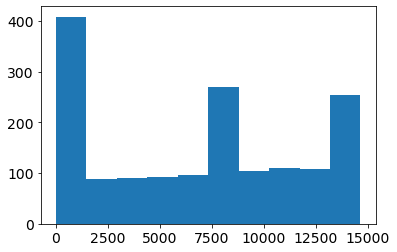

In [88]:
plt.hist(tsg_df.loc[start_times[0]:end_times[0]]['distances'])

In [102]:
start_times = ['2021-09-5 13:00:00', '2021-09-5 18:15:00', '2021-09-6 1:00:00', '2021-09-6 5:10:00', '2021-09-6 12:30:00', '2021-09-6 16:45:00', '2021-09-7 2:55:00', '2021-09-7 6:45:00', '2021-09-7 12:10:00']
end_times = ['2021-09-5 17:30:00','2021-09-5 20:30:00', '2021-09-6 4:00:00', '2021-09-6 6:45:00', '2021-09-6 15:00:00', '2021-09-6 19:20:00', '2021-09-7 5:35:00', '2021-09-7 9:00:00', '2021-09-7 15:30:00']

In [90]:
temp_gs = 28.225
sal_eddy_gs = 35.8
sal_shelf = 34

tsg_df['water_mass'] = 'slope'
tsg_df['water_mass'][tsg_df.Sal > sal_eddy_gs] = 'eddy'
tsg_df['water_mass'][tsg_df.Temp > temp_gs] = 'gulfstream'
tsg_df['water_mass'][tsg_df.Sal < sal_shelf] = 'shelf'

tsg_df['water_mass_color'] = 'green' # slope
tsg_df['water_mass_color'][tsg_df.Sal > sal_eddy_gs] = 'yellow' # eddy
tsg_df['water_mass_color'][tsg_df.Temp > temp_gs] = 'blue' # gulfstream
tsg_df['water_mass_color'][tsg_df.Sal < sal_shelf] = 'brown' # shelf

tsg_df['water_mass_code'] = 1
tsg_df['water_mass_code'][tsg_df.Sal > sal_eddy_gs] = 2
tsg_df['water_mass_code'][tsg_df.Temp > temp_gs] = 3
tsg_df['water_mass_code'][tsg_df.Sal < sal_shelf] = 0

In [91]:
optical_df['water_mass'] = 'slope'
optical_df['water_mass'][optical_df.sal > sal_eddy_gs] = 'eddy'
optical_df['water_mass'][optical_df.temp > temp_gs] = 'gulfstream'
optical_df['water_mass'][optical_df.sal < sal_shelf] = 'shelf'

optical_df['water_mass_color'] = 'green' # slope
optical_df['water_mass_color'][optical_df.sal > sal_eddy_gs] = 'yellow' # eddy
optical_df['water_mass_color'][optical_df.temp > temp_gs] = 'blue' # gulfstream
optical_df['water_mass_color'][optical_df.sal < sal_shelf] = 'brown' # shelf

optical_df['water_mass_code'] = 1
optical_df['water_mass_code'][optical_df.sal > sal_eddy_gs] = 2
optical_df['water_mass_code'][optical_df.temp > temp_gs] = 3
optical_df['water_mass_code'][optical_df.sal < sal_shelf] = 0

Make figs to match Aug and March

In [49]:
cb_colors = ['#000000',
'#E69F00',
'#56B4E9',
'#009E73',
'#F0E442',
'#0072B2',
'#D55E00',
'#CC79A7']

In [50]:
import math
def v_for_sphere(r):
    return(4/3*math.pi*r**3)

In [53]:
df = tsg_df
for i in range(len(start_times)):
    if i != 5:
        pass
    else:
        fig, ax = plt.subplots(figsize=(12,5))

        ax1 = ax.twinx()
        ax2 = ax.twinx()
        ax3 = ax.twinx()

        ax.set_ylim(20, 29)
        ax1.set_ylim(32, 36.6)
        ax2.set_ylim(.0, 2)
        ax3.set_ylim(19, 25.5)


        ax.set_xlabel("Distance (m)")
        ax.set_ylabel("Temperature (C)")
        ax1.set_ylabel("Salinity (PSU)")
        ax2.set_ylabel("Chla (mg/m3)")
        ax3.set_ylabel("Density")
        
        df_distances = get_dist(df.loc[start_times[i]:end_times[i]],df.loc[start_times[i]:end_times[i]])
        optical_df_distances = get_dist(optical_df.loc[start_times[i]:end_times[i]],df.loc[start_times[i]:end_times[i]])
        
        ax.set_xlim(df_distances[0], df_distances[-1])

        p1, = ax.plot(df_distances, df.loc[start_times[i]:end_times[i]]['Temp'], color='red', label='Temp', lw=2)
        p2, = ax1.plot(df_distances, df.loc[start_times[i]:end_times[i]]['Sal'], label='Salinity', color='blue', lw=2)
        p3,  = ax2.plot(optical_df_distances, optical_df.loc[start_times[i]:end_times[i]]['chl_ap676lh'], label='chl_ap676lh',  color='green', ls='--')
        p4, = ax3.plot(df_distances, tsg_df.loc[start_times[i]:end_times[i]]['sigma'],  color='black', lw=2)

        ax2.spines['right'].set_position(('outward', 65)) 
        ax3.spines['right'].set_position(('outward', 130)) 


        fig.autofmt_xdate(rotation=25)
  

        ax.yaxis.label.set_color(p1.get_color())
        ax1.yaxis.label.set_color(p2.get_color())
        ax2.yaxis.label.set_color(p3.get_color())
        ax3.yaxis.label.set_color(p4.get_color())

        fig.tight_layout()

        plt.savefig('simple_physical_sept.png',dpi=300)
        
        plt.show()
        
        ################################
        
        fig, ax = plt.subplots(figsize=(13.1,5))
                    
      
        ax1 = ax.twinx()
        ax2 = ax.twinx()
        ax3 = ax.twinx()
        ax4 = ax.twinx()

        ax.set_ylim(0,.075)
        ax1.set_ylim(0,.8)
        ax2.set_ylim(0,2)
        ax3.set_ylim(0, 0.008)
        ax4.set_ylim(0.00,0.02)
        
        p1, = ax.plot(optical_df_distances, optical_df.loc[start_times[i]:end_times[i]].iloc[:,29:32].mean(axis=1), label='ap(532)',  color='blue')
        p2, = ax1.plot(optical_df_distances, optical_df.loc[start_times[i]:end_times[i]].iloc[:,29+83:32+83].mean(axis=1), label='cp(532)',  color='blue', ls='--')
        p3, = ax2.plot(optical_df_distances, optical_df.loc[start_times[i]:end_times[i]]['gamma'], label='gamma',  color='purple')
        p4, = ax3.plot(optical_df_distances, optical_df.loc[start_times[i]:end_times[i]]['bbp2'], label='bbp_2',  color='grey')
        p5, = ax4.plot(optical_df_distances, optical_df.loc[start_times[i]:end_times[i]]['bbp_ratio_532'], label='bbp_ratio_532',  color='black')


        ax.set_xlabel("Distance (m)")
        
        ax.set_ylabel("ap(532)")
        ax1.set_ylabel("cp(532)")
        ax2.set_ylabel("gamma")
        ax3.set_ylabel("bpp(532)")
        ax4.set_ylabel("bpp_ratio(532)")
        
        
        df_distances = get_dist(df.loc[start_times[i]:end_times[i]],df.loc[start_times[i]:end_times[i]])
        optical_df_distances = get_dist(optical_df.loc[start_times[i]:end_times[i]],df.loc[start_times[i]:end_times[i]])
        
        ax.set_xlim(df_distances[0], df_distances[-1])

        ax2.spines['right'].set_position(('outward', 65)) 
        ax3.spines['right'].set_position(('outward', 130)) 
        ax4.spines['right'].set_position(('outward', 195)) 


        fig.autofmt_xdate(rotation=25)
  

        ax.yaxis.label.set_color(p1.get_color())
        ax1.yaxis.label.set_color(p2.get_color())
        ax2.yaxis.label.set_color(p3.get_color())
        ax3.yaxis.label.set_color(p4.get_color())
        ax4.yaxis.label.set_color(p5.get_color())

        fig.tight_layout()
        
        plt.savefig('simple_optical_sept.png',dpi=300)
        
        plt.show()
        
    
        ###########################
        
        # gaussian decomp section
            
        
        samples_gdf_subset = optical_df.loc[start_times[i]:end_times[i]]
        samples_gdf_subset = samples_gdf_subset[samples_gdf_subset['PicoCyanoA'].notnull()]
        sample_df_distances = get_dist(samples_gdf_subset,df.loc[start_times[i]:end_times[i]])
        optical_df_distances = get_dist(optical_df.loc[start_times[i]:end_times[i]],df.loc[start_times[i]:end_times[i]])

        
        fig, (ax,ax1) = plt.subplots(2,1,figsize=(11,8))
        # normalize by the total
#         total_pop = samples_gdf_subset.prosa*v_for_sphere(.3) + samples_gdf_subset.synsa*v_for_sphere(.5) + samples_gdf_subset.picosa*v_for_sphere(1) +  samples_gdf_subset.nanosa*v_for_sphere(3)
#         # total_pop = total_pop / samples_gdf_subset.chla_lh
        
#         y = np.row_stack((samples_gdf_subset.prosa*v_for_sphere(.3)/total_pop, samples_gdf_subset.synsa*v_for_sphere(.5)/total_pop, samples_gdf_subset.picosa*v_for_sphere(1)/total_pop,  samples_gdf_subset.nanosa*v_for_sphere(3)/total_pop))  
        
        
        ###
        
        total_pop = samples_gdf_subset.PicoCyanoA*v_for_sphere(.3) + samples_gdf_subset.SynA*v_for_sphere(.5) + samples_gdf_subset.PeuksA*v_for_sphere(1)## +  samples_gdf_subset.BacteriaA/10
    
        y = np.row_stack((samples_gdf_subset.PicoCyanoA*v_for_sphere(.3)/total_pop, samples_gdf_subset.SynA*v_for_sphere(.5)/total_pop, samples_gdf_subset.PeuksA*v_for_sphere(1)/total_pop))#,  (samples_gdf_subset.BacteriaA/10)/total_pop))  
        
        
        # this call to 'cumsum' (cumulative sum), passing in your y data, 
        # is necessary to avoid having to manually order the datasets
        x = sample_df_distances
        y_stack = np.cumsum(y, axis=0)   # a 3x10 array


        ax.fill_between(x, 0, y_stack[0,:], facecolor=cb_colors[0], alpha=.7, label='Pro')
        ax.fill_between(x, y_stack[0,:], y_stack[1,:], facecolor=cb_colors[1], alpha=.7, label='Syn')
        ax.fill_between(x, y_stack[1,:], y_stack[2,:], facecolor=cb_colors[2],alpha=0.7, label='PicoEuk')
#         ax.fill_between(x, y_stack[2,:], y_stack[3,:], facecolor=cb_colors[3],alpha=0.7,label='Bacteria')
        
        ax.set_xlim(df_distances[0], df_distances[-1])
        
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        if optical_df.loc[start_times[i]:end_times[i]].empty:
            pass
        else:
                        
            chlb = optical_df.loc[start_times[i]:end_times[i]]['agaus660']
            PSC = optical_df.loc[start_times[i]:end_times[i]]['agaus523']
            PPC = optical_df.loc[start_times[i]:end_times[i]]['agaus492']
            chlc = optical_df.loc[start_times[i]:end_times[i]]['agaus638']
            PE = optical_df.loc[start_times[i]:end_times[i]]['agaus550']

            total_pigment = chlb + chlc + PE +PSC# +PPC

            y = np.row_stack((chlb/total_pigment, chlc/total_pigment, PE/total_pigment, PSC/total_pigment))#, PPC/total_pigment))   
            # this call to 'cumsum' (cumulative sum), passing in your y data, 
            # is necessary to avoid having to manually order the datasets
            x = optical_df_distances
            y_stack = np.cumsum(y, axis=0)   # a 3x10 array


            ax1.fill_between(x, 0, y_stack[0,:], facecolor=cb_colors[4], alpha=.7, label='Chl-b')
            ax1.fill_between(x, y_stack[0,:], y_stack[1,:], facecolor=cb_colors[5], alpha=.7, label='Chl-c')
            ax1.fill_between(x, y_stack[1,:], y_stack[2,:], facecolor=cb_colors[6], label='PE')
            ax1.fill_between(x, y_stack[2,:], y_stack[3,:], facecolor=cb_colors[7], label='PSC')
#             ax1.fill_between(x, y_stack[3,:], y_stack[4,:], facecolor="blue", label='PPC')

            ax1.set_xlim(df_distances[0], df_distances[-1])
            ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
            ppc_dict = {
                'chlb':optical_df.loc[start_times[i]:end_times[i]]['agaus660'].values,
                'PSC' : optical_df.loc[start_times[i]:end_times[i]]['agaus523'].values,
                'chlc' : optical_df.loc[start_times[i]:end_times[i]]['agaus638'].values,
                'PE' : optical_df.loc[start_times[i]:end_times[i]]['agaus550'].values}
        
        
            ax_shannon = ax1.twinx()
            shannon_h = []
            for i in range(len(optical_df.loc[start_times[i]:end_times[i]]['agaus660'].values)):
                elems = [elem[i] for elem in ppc_dict.values()]
                keys = ['chlb', 'PSC', 'chlc', 'PE']
                single_dict = {
                    keys[0] : elems[0],
                    keys[1] : elems[1],
                    keys[2] : elems[2],
                    keys[3] : elems[3],
                }
                shannon_h.append(sdi(single_dict))
            ax_shannon.plot(optical_df_distances,shannon_h, c='k')
            ax_shannon.set_ylim(0,1.5)

            
        plt.savefig('pcc_gauss_sept.png',dpi=300)
        
        plt.show()
        
        print('#######################################################################')
        
#         plt.savefig('figs/trios_transect_aug'+titles[i]+'.png')
        

NameError: name 'start_times' is not defined

In [259]:
plt.rcParams.update({'font.size': 20})

In [115]:
optical_df

dt      ap_1      ap_2  ap_3  ap_4  \
utc_dt                                                                     
2021-09-05 12:26:00  2021/09/05 12:26:00       NaN       NaN   NaN   NaN   
2021-09-05 12:28:00  2021/09/05 12:28:00       NaN       NaN   NaN   NaN   
2021-09-05 12:30:00  2021/09/05 12:30:00       NaN       NaN   NaN   NaN   
2021-09-05 12:32:00  2021/09/05 12:32:00       NaN       NaN   NaN   NaN   
2021-09-05 12:34:00  2021/09/05 12:34:00       NaN       NaN   NaN   NaN   
...                                  ...       ...       ...   ...   ...   
2021-09-07 22:40:00  2021/09/07 22:40:00       NaN       NaN   NaN   NaN   
2021-09-07 22:42:00  2021/09/07 22:42:00       NaN       NaN   NaN   NaN   
2021-09-07 22:44:00  2021/09/07 22:44:00       NaN       NaN   NaN   NaN   
2021-09-07 22:46:00  2021/09/07 22:46:00  0.001403 -0.001455   NaN   NaN   
2021-09-07 22:48:00  2021/09/07 22:48:00       NaN       NaN   NaN   NaN   

                         ap_5      ap_6      ap_7      ap_8      ap_9  ...  \
utc_dt                                                                 ...   
2021-09-05 12:26:00       NaN       NaN       NaN       NaN       NaN  ...   
2021-09-05 12:28:00       NaN       NaN       NaN       NaN       NaN  ...   
2021-09-05 12:30:00       NaN       NaN       NaN       NaN       NaN  ...   
2021-09-05 12:32:00       NaN       NaN       NaN       NaN       NaN  ...   
2021-09-05 12:34:00       NaN       NaN       NaN       NaN       NaN  ...   
...                       ...       ...       ...       ...       ...  ...   
2021-09-07 22:40:00       NaN       NaN  0.006088  0.006661  0.006902  ...   
2021-09-07 22:42:00  0.006639  0.006288  0.002259  0.003187  0.005718  ...   
2021-09-07 22:44:00       NaN       NaN -0.001021  0.002577  0.001943  ...   
2021-09-07 22:46:00       NaN  0.001813 -0.000893 -0.000692  0.001962  ...   
2021-09-07 22:48:00       NaN       NaN -0.000395  0.000845  0.003551  ...   

                           lon  SynA  PeuksA  PicoCyanoA  SynB  PeuksB  \
utc_dt                                                                   
2021-09-05 12:26:00 -74.903382   NaN     NaN         NaN   NaN     NaN   
2021-09-05 12:28:00 -74.903330   NaN     NaN         NaN   NaN     NaN   
2021-09-05 12:30:00 -74.903293   NaN     NaN         NaN   NaN     NaN   
2021-09-05 12:32:00 -74.903272   NaN     NaN         NaN   NaN     NaN   
2021-09-05 12:34:00 -74.903267   NaN     NaN         NaN   NaN     NaN   
...                        ...   ...     ...         ...   ...     ...   
2021-09-07 22:40:00 -74.798838   NaN     NaN         NaN   NaN     NaN   
2021-09-07 22:42:00 -74.796865   NaN     NaN         NaN   NaN     NaN   
2021-09-07 22:44:00 -74.800720   NaN     NaN         NaN   NaN     NaN   
2021-09-07 22:46:00 -74.803680   NaN     NaN         NaN   NaN     NaN   
2021-09-07 22:48:00 -74.807818   NaN     NaN         NaN   NaN     NaN   

                     PicoCyanoB  BacteriaA  BacteriaB  ChlaAvg  
utc_dt                                                          
2021-09-05 12:26:00         NaN        NaN        NaN      NaN  
2021-09-05 12:28:00         NaN        NaN        NaN      NaN  
2021-09-05 12:30:00         NaN        NaN        NaN      NaN  
2021-09-05 12:32:00         NaN        NaN        NaN      NaN  
2021-09-05 12:34:00         NaN        NaN        NaN      NaN  
...                         ...        ...        ...      ...  
2021-09-07 22:40:00         NaN        NaN        NaN      NaN  
2021-09-07 22:42:00         NaN        NaN        NaN      NaN  
2021-09-07 22:44:00         NaN        NaN        NaN      NaN  
2021-09-07 22:46:00         NaN        NaN        NaN      NaN  
2021-09-07 22:48:00         NaN        NaN        NaN      NaN  

[1592 rows x 370 columns]

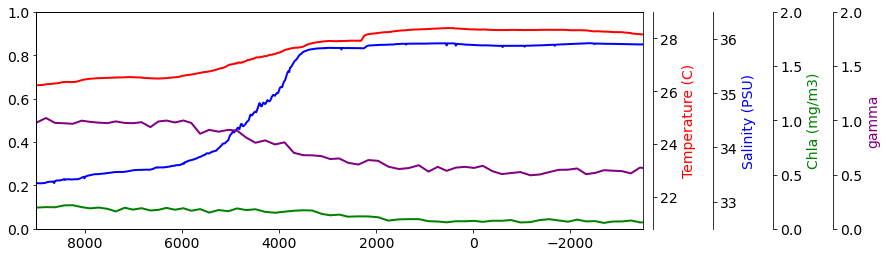

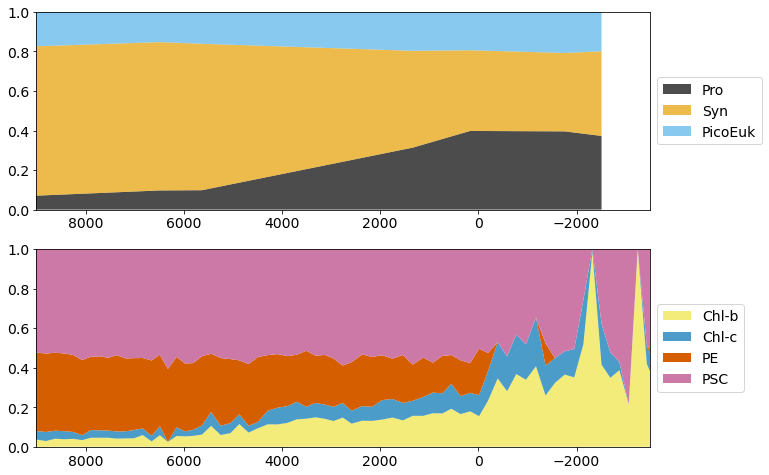

#######################################################################


In [114]:
df = tsg_df

front_location = 10747
for i in range(len(start_times)):
    if i != 5:
        pass
    else:
        fig, ax = plt.subplots(figsize=(12.55,3.8))

        ax0 = ax.twinx()
        ax1 = ax.twinx()
        ax2 = ax.twinx()
        ax3 = ax.twinx()

        ax0.set_ylim(20.8, 29)
        ax1.set_ylim(32.5, 36.5)
        ax2.set_ylim(0,2)
        ax3.set_ylim(0,2)


#         ax.set_xlabel("Distance (m)")
        ax0.set_ylabel("Temperature (C)")
        ax1.set_ylabel("Salinity (PSU)")
        ax2.set_ylabel("Chla (mg/m3)")
        ax3.set_ylabel("gamma")
        
        df_distances = -1*(np.array(get_dist(df.loc[start_times[i]:end_times[i]],df.loc[start_times[i]:end_times[i]]))-front_location)
        optical_df_distances = -1*(np.array(get_dist(optical_df.loc[start_times[i]:end_times[i]],df.loc[start_times[i]:end_times[i]]))-front_location)
        
#         ax.set_xlim(df_distances[-1], df_distances[0])
        ax.set_xlim(9000, -3500)

        p1, = ax0.plot(df_distances, df.loc[start_times[i]:end_times[i]]['Temp'], color='red', label='Temp', lw=2)
        p2, = ax1.plot(df_distances, df.loc[start_times[i]:end_times[i]]['Sal'], label='Salinity', color='blue', lw=2)
        p3, = ax2.plot(optical_df_distances, optical_df.loc[start_times[i]:end_times[i]]['chl_ap676lh'], label='chl_ap676lh',  color='green', lw=2)
        p4, = ax3.plot(optical_df_distances, optical_df.loc[start_times[i]:end_times[i]]['gamma'], label='gamma',  color='purple', lw=2)
    
        ax0.spines['right'].set_position(('outward', 10)) 
        ax1.spines['right'].set_position(('outward', 70)) 
        ax2.spines['right'].set_position(('outward', 130)) 
        ax3.spines['right'].set_position(('outward', 190)) 
  
        ax0.yaxis.label.set_color(p1.get_color())
        ax1.yaxis.label.set_color(p2.get_color())
        ax2.yaxis.label.set_color(p3.get_color())
        ax3.yaxis.label.set_color(p4.get_color())

        fig.tight_layout()

        plt.savefig('paper_physical_optical_sept.png',dpi=300)
        
        plt.show()
    
        ###########################
        
        # gaussian decomp section
            
        samples_gdf_subset = optical_df.loc[start_times[i]:end_times[i]]
        samples_gdf_subset = samples_gdf_subset[samples_gdf_subset['PicoCyanoA'].notnull()]
        
        sample_df_distances = -1*(np.array(get_dist(samples_gdf_subset,df.loc[start_times[i]:end_times[i]]))-front_location)
        optical_df_distances = -1*(np.array(get_dist(optical_df.loc[start_times[i]:end_times[i]],df.loc[start_times[i]:end_times[i]]))-front_location)

        
        fig, (ax,ax1) = plt.subplots(2,1,figsize=(11,8))
        
        total_pop = samples_gdf_subset.PicoCyanoA*v_for_sphere(.3) + samples_gdf_subset.SynA*v_for_sphere(.5) + samples_gdf_subset.PeuksA*v_for_sphere(1)## +  samples_gdf_subset.BacteriaA/10
    
        y = np.row_stack((samples_gdf_subset.PicoCyanoA*v_for_sphere(.3)/total_pop, samples_gdf_subset.SynA*v_for_sphere(.5)/total_pop, samples_gdf_subset.PeuksA*v_for_sphere(1)/total_pop))#,  (samples_gdf_subset.BacteriaA/10)/total_pop))  
        
        
        # this call to 'cumsum' (cumulative sum), passing in your y data, 
        # is necessary to avoid having to manually order the datasets
        x = sample_df_distances
        y_stack = np.cumsum(y, axis=0)   # a 3x10 array


        ax.fill_between(x, 0, y_stack[0,:], facecolor=cb_colors[0], alpha=.7, label='Pro')
        ax.fill_between(x, y_stack[0,:], y_stack[1,:], facecolor=cb_colors[1], alpha=.7, label='Syn')
        ax.fill_between(x, y_stack[1,:], y_stack[2,:], facecolor=cb_colors[2],alpha=0.7, label='PicoEuk')
#         ax.fill_between(x, y_stack[2,:], y_stack[3,:], facecolor=cb_colors[3],alpha=0.7,label='Bacteria')
        
#         ax.set_xlim(df_distances[-1], df_distances[0])
        ax.set_xlim(9000, -3500)
        ax1.set_xlim(9000, -3500)
        
        ax.set_ylim(0,1)
        ax1.set_ylim(0,1)
        
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        if optical_df.loc[start_times[i]:end_times[i]].empty:
            pass
        else:
                        
            chlb = optical_df.loc[start_times[i]:end_times[i]]['agaus660']
            PSC = optical_df.loc[start_times[i]:end_times[i]]['agaus523']
            PPC = optical_df.loc[start_times[i]:end_times[i]]['agaus492']
            chlc = optical_df.loc[start_times[i]:end_times[i]]['agaus638']
            PE = optical_df.loc[start_times[i]:end_times[i]]['agaus550']

            total_pigment = chlb + chlc + PE +PSC# +PPC

            y = np.row_stack((chlb/total_pigment, chlc/total_pigment, PE/total_pigment, PSC/total_pigment))#, PPC/total_pigment))   
            # this call to 'cumsum' (cumulative sum), passing in your y data, 
            # is necessary to avoid having to manually order the datasets
            x = optical_df_distances
            y_stack = np.cumsum(y, axis=0)   # a 3x10 array


            ax1.fill_between(x, 0, y_stack[0,:], facecolor=cb_colors[4], alpha=.7, label='Chl-b')
            ax1.fill_between(x, y_stack[0,:], y_stack[1,:], facecolor=cb_colors[5], alpha=.7, label='Chl-c')
            ax1.fill_between(x, y_stack[1,:], y_stack[2,:], facecolor=cb_colors[6], label='PE')
            ax1.fill_between(x, y_stack[2,:], y_stack[3,:], facecolor=cb_colors[7], label='PSC')
#             ax1.fill_between(x, y_stack[3,:], y_stack[4,:], facecolor="blue", label='PPC')

#             ax1.set_xlim(df_distances[-1], df_distances[0])
            ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
            ppc_dict = {
                'chlb':optical_df.loc[start_times[i]:end_times[i]]['agaus660'].values,
                'PSC' : optical_df.loc[start_times[i]:end_times[i]]['agaus523'].values,
                'chlc' : optical_df.loc[start_times[i]:end_times[i]]['agaus638'].values,
                'PE' : optical_df.loc[start_times[i]:end_times[i]]['agaus550'].values}

#             ax_shannon = ax1.twinx()
#             shannon_h = []
#             for i in range(len(optical_df.loc[start_times[i]:end_times[i]]['agaus660'].values)):
#                 elems = [elem[i] for elem in ppc_dict.values()]
#                 keys = ['chlb', 'PSC', 'chlc', 'PE']
#                 single_dict = {
#                     keys[0] : elems[0],
#                     keys[1] : elems[1],
#                     keys[2] : elems[2],
#                     keys[3] : elems[3],
#                 }
#                 shannon_h.append(sdi(single_dict))
#             ax_shannon.plot(optical_df_distances,shannon_h, c='k')
#             ax_shannon.set_ylim(0,1.5)

            
        plt.savefig('paper_pcc_gauss_sept.png',dpi=300)
        
        plt.show()
        
        print('#######################################################################')
                

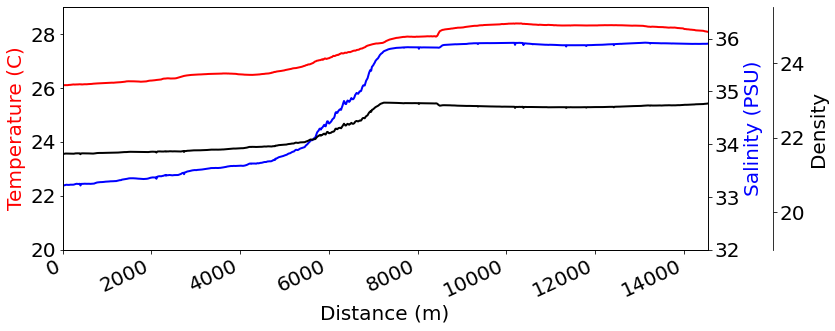

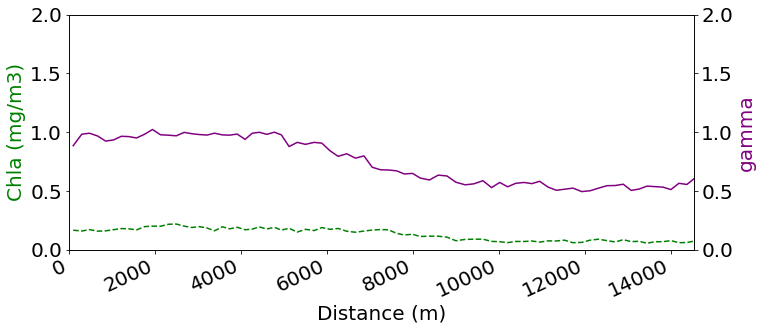

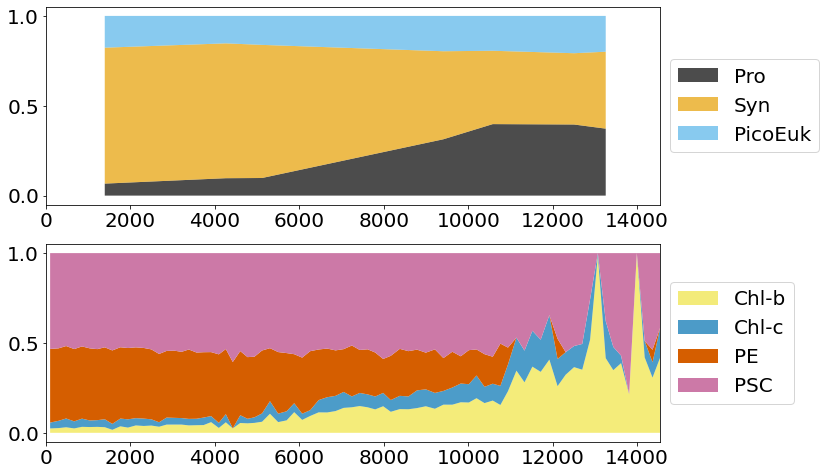

#######################################################################


In [260]:
df = tsg_df
for i in range(len(start_times)):
    if i != 5:
        pass
    else:
        fig, ax = plt.subplots(figsize=(12,5))

        ax1 = ax.twinx()
#         ax2 = ax.twinx()
        ax3 = ax.twinx()

        ax.set_ylim(20, 29)
        ax1.set_ylim(32, 36.6)
#         ax2.set_ylim(.0, 2)
        ax3.set_ylim(19, 25.5)


        ax.set_xlabel("Distance (m)")
        ax.set_ylabel("Temperature (C)")
        ax1.set_ylabel("Salinity (PSU)")
#         ax2.set_ylabel("Chla (mg/m3)")
        ax3.set_ylabel("Density")
        
        df_distances = get_dist(df.loc[start_times[i]:end_times[i]],df.loc[start_times[i]:end_times[i]])
        optical_df_distances = get_dist(optical_df.loc[start_times[i]:end_times[i]],df.loc[start_times[i]:end_times[i]])
        
        ax.set_xlim(df_distances[0], df_distances[-1])

        p1, = ax.plot(df_distances, df.loc[start_times[i]:end_times[i]]['Temp'], color='red', label='Temp', lw=2)
        p2, = ax1.plot(df_distances, df.loc[start_times[i]:end_times[i]]['Sal'], label='Salinity', color='blue', lw=2)
#         p3,  = ax2.plot(optical_df_distances, optical_df.loc[start_times[i]:end_times[i]]['chl_ap676lh'], label='chl_ap676lh',  color='green', ls='--')
        p4, = ax3.plot(df_distances, tsg_df.loc[start_times[i]:end_times[i]]['sigma'],  color='black', lw=2)

#         ax2.spines['right'].set_position(('outward', 65)) 
        ax3.spines['right'].set_position(('outward', 65)) 


        fig.autofmt_xdate(rotation=25)
  

        ax.yaxis.label.set_color(p1.get_color())
        ax1.yaxis.label.set_color(p2.get_color())
#         ax2.yaxis.label.set_color(p3.get_color())
        ax3.yaxis.label.set_color(p4.get_color())

        fig.tight_layout()

        plt.savefig('simplest_physical_sept.png',dpi=300)
        
        plt.show()
        
        ################################
        
        fig, ax = plt.subplots(figsize=(11,5))
                    

        ax2 = ax.twinx()

        ax.set_ylim(0,2)
        ax2.set_ylim(0,2)
        
        p1, = ax.plot(optical_df_distances, optical_df.loc[start_times[i]:end_times[i]]['chl_ap676lh'], label='chl_ap676lh',  color='green', ls='--')
        p2, = ax2.plot(optical_df_distances, optical_df.loc[start_times[i]:end_times[i]]['gamma'], label='gamma',  color='purple')
    

        ax.set_xlabel("Distance (m)")
        
        ax.set_ylabel("Chla (mg/m3)")
        ax2.set_ylabel("gamma")
        
        
        df_distances = get_dist(df.loc[start_times[i]:end_times[i]],df.loc[start_times[i]:end_times[i]])
        optical_df_distances = get_dist(optical_df.loc[start_times[i]:end_times[i]],df.loc[start_times[i]:end_times[i]])
        
        ax.set_xlim(df_distances[0], df_distances[-1])

#         ax2.spines['right'].set_position(('outward', 65)) 


        fig.autofmt_xdate(rotation=25)
  

        ax.yaxis.label.set_color(p1.get_color())
        ax2.yaxis.label.set_color(p2.get_color())

        fig.tight_layout()
        
        plt.savefig('simplest_optical_sept.png',dpi=300)
        
        plt.show()
        
    
        ###########################
        
        # gaussian decomp section
            
        
        samples_gdf_subset = optical_df.loc[start_times[i]:end_times[i]]
        samples_gdf_subset = samples_gdf_subset[samples_gdf_subset['PicoCyanoA'].notnull()]
        sample_df_distances = get_dist(samples_gdf_subset,df.loc[start_times[i]:end_times[i]])
        optical_df_distances = get_dist(optical_df.loc[start_times[i]:end_times[i]],df.loc[start_times[i]:end_times[i]])

        
        fig, (ax,ax1) = plt.subplots(2,1,figsize=(11,8))
        # normalize by the total
#         total_pop = samples_gdf_subset.prosa*v_for_sphere(.3) + samples_gdf_subset.synsa*v_for_sphere(.5) + samples_gdf_subset.picosa*v_for_sphere(1) +  samples_gdf_subset.nanosa*v_for_sphere(3)
#         # total_pop = total_pop / samples_gdf_subset.chla_lh
        
#         y = np.row_stack((samples_gdf_subset.prosa*v_for_sphere(.3)/total_pop, samples_gdf_subset.synsa*v_for_sphere(.5)/total_pop, samples_gdf_subset.picosa*v_for_sphere(1)/total_pop,  samples_gdf_subset.nanosa*v_for_sphere(3)/total_pop))  
        
        
        ###
        
        total_pop = samples_gdf_subset.PicoCyanoA*v_for_sphere(.3) + samples_gdf_subset.SynA*v_for_sphere(.5) + samples_gdf_subset.PeuksA*v_for_sphere(1)## +  samples_gdf_subset.BacteriaA/10
    
        y = np.row_stack((samples_gdf_subset.PicoCyanoA*v_for_sphere(.3)/total_pop, samples_gdf_subset.SynA*v_for_sphere(.5)/total_pop, samples_gdf_subset.PeuksA*v_for_sphere(1)/total_pop))#,  (samples_gdf_subset.BacteriaA/10)/total_pop))  
        
        
        # this call to 'cumsum' (cumulative sum), passing in your y data, 
        # is necessary to avoid having to manually order the datasets
        x = sample_df_distances
        y_stack = np.cumsum(y, axis=0)   # a 3x10 array


        ax.fill_between(x, 0, y_stack[0,:], facecolor=cb_colors[0], alpha=.7, label='Pro')
        ax.fill_between(x, y_stack[0,:], y_stack[1,:], facecolor=cb_colors[1], alpha=.7, label='Syn')
        ax.fill_between(x, y_stack[1,:], y_stack[2,:], facecolor=cb_colors[2],alpha=0.7, label='PicoEuk')
#         ax.fill_between(x, y_stack[2,:], y_stack[3,:], facecolor=cb_colors[3],alpha=0.7,label='Bacteria')
        
        ax.set_xlim(df_distances[0], df_distances[-1])
        
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        if optical_df.loc[start_times[i]:end_times[i]].empty:
            pass
        else:
                        
            chlb = optical_df.loc[start_times[i]:end_times[i]]['agaus660']
            PSC = optical_df.loc[start_times[i]:end_times[i]]['agaus523']
            PPC = optical_df.loc[start_times[i]:end_times[i]]['agaus492']
            chlc = optical_df.loc[start_times[i]:end_times[i]]['agaus638']
            PE = optical_df.loc[start_times[i]:end_times[i]]['agaus550']

            total_pigment = chlb + chlc + PE +PSC# +PPC

            y = np.row_stack((chlb/total_pigment, chlc/total_pigment, PE/total_pigment, PSC/total_pigment))#, PPC/total_pigment))   
            # this call to 'cumsum' (cumulative sum), passing in your y data, 
            # is necessary to avoid having to manually order the datasets
            x = optical_df_distances
            y_stack = np.cumsum(y, axis=0)   # a 3x10 array


            ax1.fill_between(x, 0, y_stack[0,:], facecolor=cb_colors[4], alpha=.7, label='Chl-b')
            ax1.fill_between(x, y_stack[0,:], y_stack[1,:], facecolor=cb_colors[5], alpha=.7, label='Chl-c')
            ax1.fill_between(x, y_stack[1,:], y_stack[2,:], facecolor=cb_colors[6], label='PE')
            ax1.fill_between(x, y_stack[2,:], y_stack[3,:], facecolor=cb_colors[7], label='PSC')
#             ax1.fill_between(x, y_stack[3,:], y_stack[4,:], facecolor="blue", label='PPC')

            ax1.set_xlim(df_distances[0], df_distances[-1])
            ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
            ppc_dict = {
                'chlb':optical_df.loc[start_times[i]:end_times[i]]['agaus660'].values,
                'PSC' : optical_df.loc[start_times[i]:end_times[i]]['agaus523'].values,
                'chlc' : optical_df.loc[start_times[i]:end_times[i]]['agaus638'].values,
                'PE' : optical_df.loc[start_times[i]:end_times[i]]['agaus550'].values}
        
            
        plt.savefig('simplest_pcc_gauss_sept.png',dpi=300)
        
        plt.show()
        
        print('#######################################################################')
                

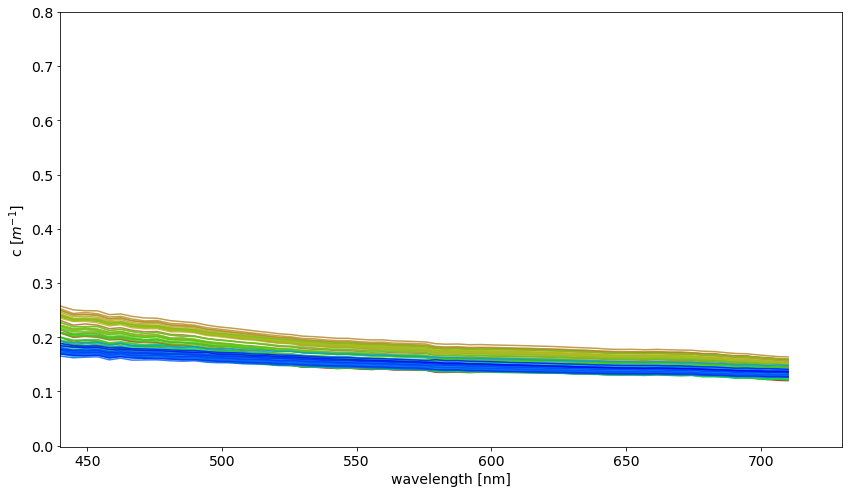

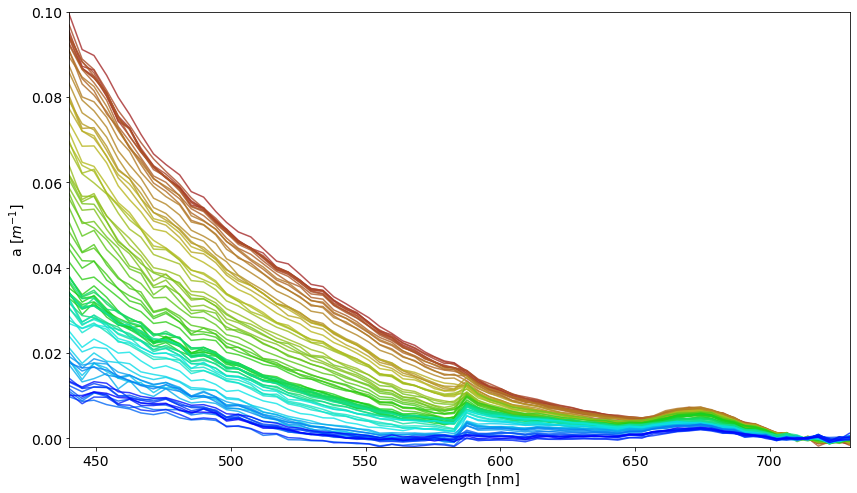

In [252]:
from colour import Color

df_subset = optical_df.loc[start_times[5]:end_times[5]]

colors = list(Color("brown").range_to(Color("blue"),len(df_subset)))
hex_colors = [j.hex for j in colors]

fig, ax = plt.subplots(figsize=(14,8))
for i in range(len(df_subset)):
    if ~df_subset.iloc[i,1:82].isnull().values.all():
        ax.plot(acs_wavelength,df_subset.iloc[i,1+83:82+83].rolling(window=1, win_type='triang').mean(), alpha=.8, c=hex_colors[i])
ax.set_ylim(-0.002,.8)
ax.set_xlim(440,730)
#ax.set_title('Particulate Abs')
ax.set_ylabel('c [$m^{-1}$]')
ax.set_xlabel('wavelength [nm]')  
# plt.title('Absorption colored by time (blue to brown) across an open ocean to coastal transect')
plt.savefig('figs/sept_c_spec.png',dpi=300)
plt.show()


fig, ax = plt.subplots(figsize=(14,8))
for i in range(len(df_subset)):
    if ~df_subset.iloc[i,1:82].isnull().values.all():
        ax.plot(acs_wavelength,df_subset.iloc[i,1:82].rolling(window=1, win_type='triang').mean(), alpha=.8, c=hex_colors[i])
ax.set_ylim(-0.002,.1)
ax.set_xlim(440,730)
#ax.set_title('Particulate Abs')
ax.set_ylabel('a [$m^{-1}$]')
ax.set_xlabel('wavelength [nm]')  
# plt.title('Absorption colored by time (blue to brown) across an open ocean to coastal transect')
plt.savefig('figs/sept_a_spec.png',dpi=300)
plt.show()

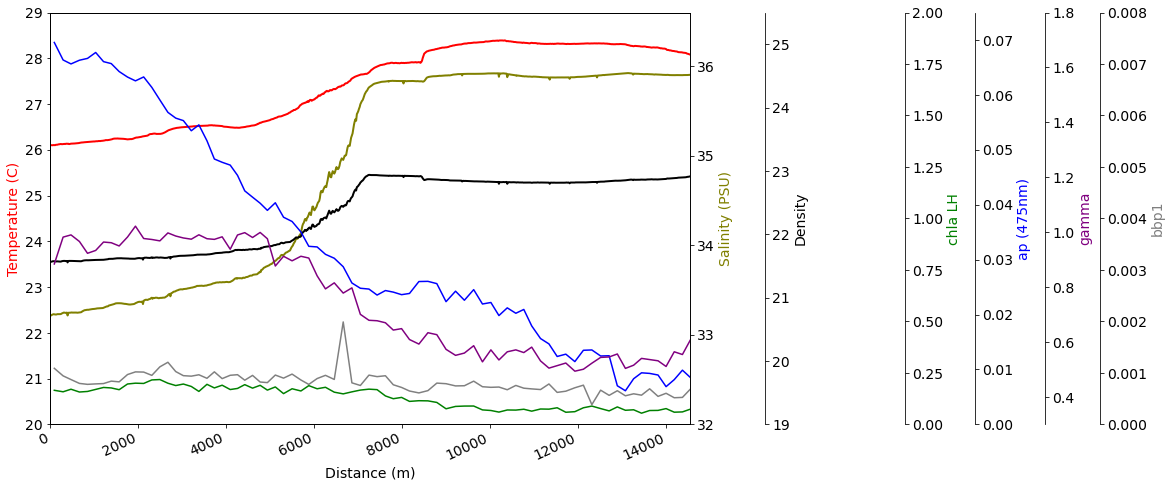

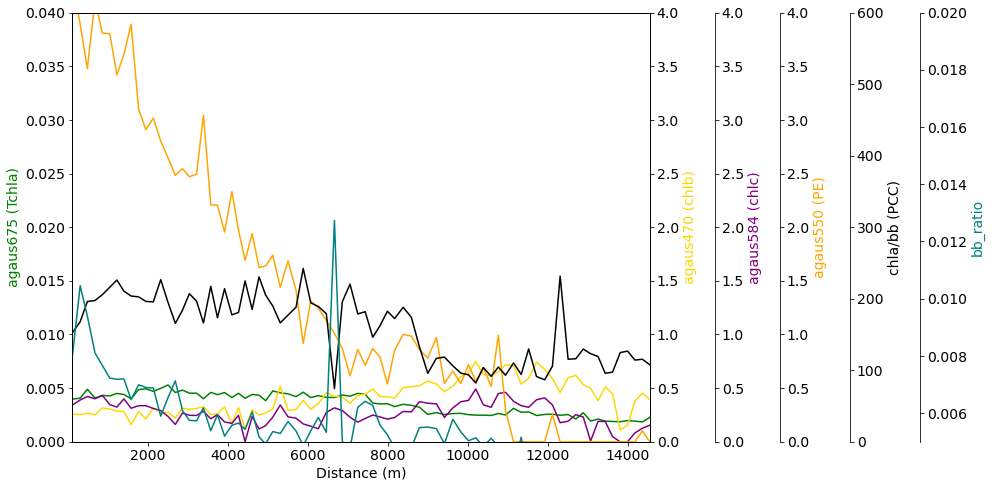

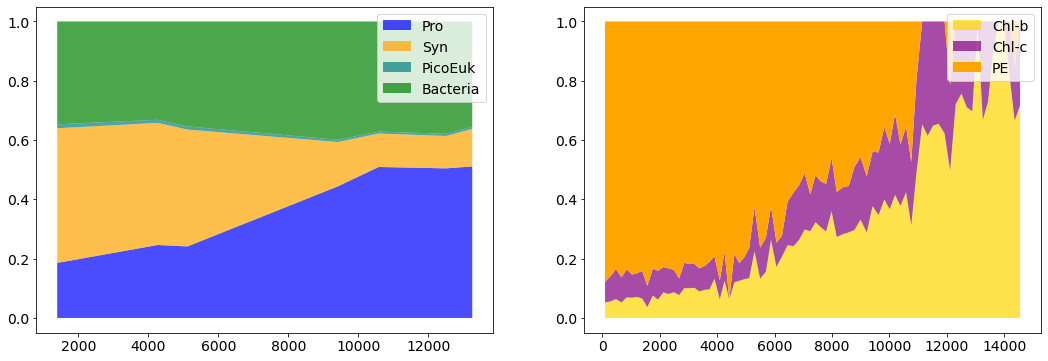

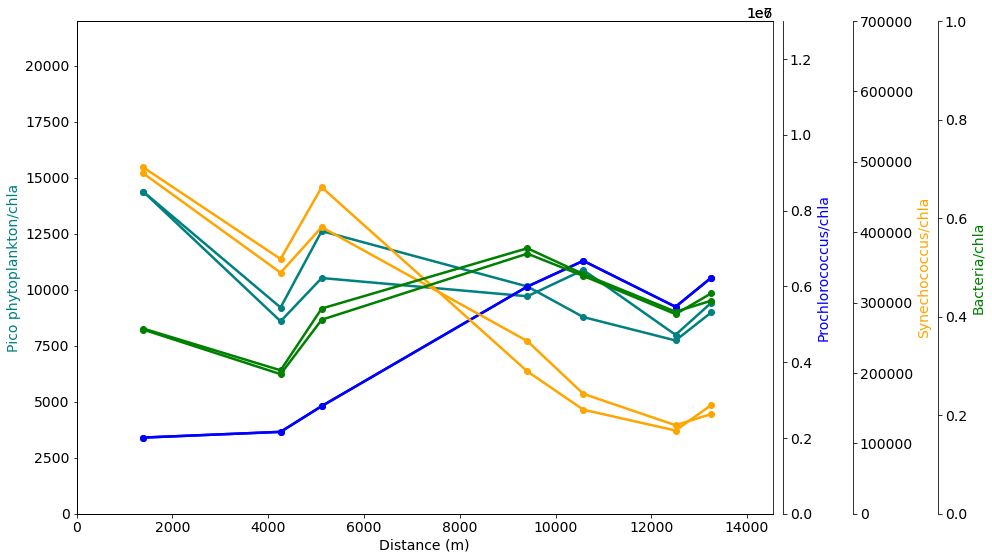

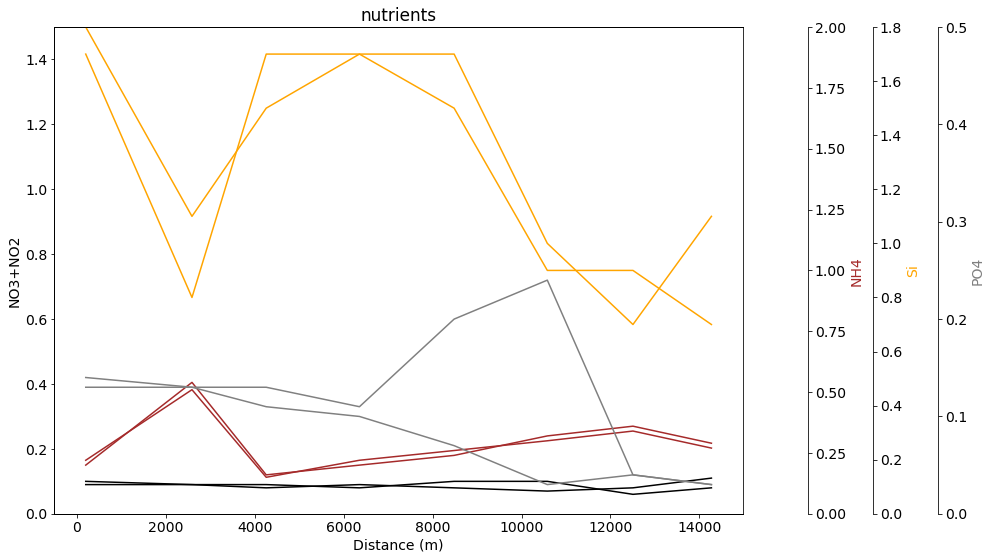

#######################################################################


In [207]:
df = tsg_df
for i in range(len(start_times)):
#     print(i)
    if i != 5:
        continue
# for i in range(len(start_times)):
# for i in [0,1,2,5,7,9,10,12]:
#     if trios_df.loc[start_times[i]:end_times[i]]['chla_oci'].empty:
#         pass
#     if profiles.loc[start_times[i]:end_times[i]].empty:
#         pass
# # #     elif hplc_df.loc[start_times[i]:end_times[i]]['datetime'].empty:
# # #         pass
#     else:
#         if not trios_gdf.loc[start_times[i]:end_times[i]]['440'].empty:
#             print('we have trios data')
#         else:
#             print('no TriOS data')

    # time series plot
    fig, ax = plt.subplots(figsize=(16.5,7))

    ax1 = ax.twinx()
#         ax2 = ax.twinx()
#         ax3 = ax.twinx()
    ax4 = ax.twinx()
#         ax5 = ax.twinx()
    ax6 = ax.twinx()
#         ax7 = ax.twinx()
    ax8 = ax.twinx()
    ax9 = ax.twinx()
    ax10 = ax.twinx()

    ax.set_ylim(20, 29)
    ax1.set_ylim(32, 36.6)
#         ax2.set_ylim(.0, .24)
#         ax3.set_ylim(.0, 2)
#         ax4.set_ylim(.07, .50)
#         ax5.set_ylim(.07, .50)
    ax4.set_ylim(19, 25.5)
#         ax5.set_ylim(-.1, .1)
    ax6.set_ylim(0,2)
#         ax7.set_ylim(0,0.0085)
    ax8.set_ylim(0,.075)
    ax9.set_ylim(0.3,1.8)
    ax10.set_ylim(0,0.008)

    ax.set_xlabel("Distance (m)")
    ax.set_ylabel("Temperature (C)")
    ax1.set_ylabel("Salinity (PSU)")
#         ax2.set_ylabel("CDOM (volts)")
#         ax3.set_ylabel("Chla (mg/m3)")
    ax4.set_ylabel("Density")
#         ax5.set_ylabel("Density Grad")
    ax6.set_ylabel("chla LH")
#         ax7.set_ylabel("agaus523 (phyco)")
    ax8.set_ylabel("ap (475nm)")
    ax9.set_ylabel("gamma")
    ax10.set_ylabel("bbp1")

    color1 = plt.cm.viridis(0)
    color2 = plt.cm.viridis(0.5)
    color3 = plt.cm.viridis(.9)

    df_distances = get_dist(df.loc[start_times[i]:end_times[i]],df.loc[start_times[i]:end_times[i]])
    ax.set_xlim(df_distances[0], df_distances[-1])

    p1, = ax.plot(df_distances, df.loc[start_times[i]:end_times[i]]['Temp'], color='red', label='Temp', lw=2)
    p2, = ax1.plot(df_distances, df.loc[start_times[i]:end_times[i]]['Sal'], label='Salinity', color='olive', lw=2)

#         p3  = ax2.scatter(cdom_data_x, cdom_data_y, color='brown', label='CDOM', s=1)


#         trios_df_distances = get_dist(trios_gdf.loc[start_times[i]:end_times[i]],df.loc[start_times[i]:end_times[i]])

#         trios_data_x = trios_gdf.loc[start_times[i]:end_times[i]].rolling(window=6*1).mean().index
#         trios_data_y = trios_gdf.loc[start_times[i]:end_times[i]].rolling(window=6*1).mean()['chla_oci']
#         p4  = ax3.plot(trios_df_distances, trios_data_y, color='green', label='Chla', ls='--')

#         p5 = ax4.scatter(hplc_df.loc[start_times[i]:end_times[i]].index, hplc_df.loc[start_times[i]:end_times[i]]['[TChl a]'], 
#                    color='orange', label='TChl a', s=50)
#         p6 = ax5.scatter(hplc_df.loc[start_times[i]:end_times[i]].index, hplc_df.loc[start_times[i]:end_times[i]]['[Zea]'], 
#                    color='purple', label='Zea', s=50)

#         ax.set_title(titles[i])

    p5, = ax4.plot(df_distances, tsg_df.loc[start_times[i]:end_times[i]]['sigma'],  color='black', lw=2)
#         p6, = ax5.plot(df_distances, tsg_df.loc[start_times[i]:end_times[i]]['sigma_grad'], label='Density grad',  color='grey')



#         df_subset = profiles.loc[start_times[i]:end_times[i]]
#         # now add in the proper locations for these guys
#         df_subset = profile_locs(df_subset)

    # integrate down to z depth
    #depths = [-2,-5,-10,-20,-40,-60,-80, -100]
#         depths=[-2,-10,-20,-40,-80]

#         colors = list(Color("black").range_to(Color("blue"),len(depths)))
#         hex_colors = [j.hex for j in colors]

#         for idx, z in enumerate(depths):
#             # cut it off at depth (dBars) >= z
#             df_tmp = df_subset[df_subset['depth (dBars)'] >= z] 
#             df_tmp_grouped = df_tmp.groupby('profile_num').median()
#             df_tmp_grouped['datetime'] = pd.to_datetime('2021-1-1') + pd.to_timedelta(df_tmp_grouped.time, unit='D') - pd.Timedelta(days=1)
#             df_subset_distances = get_dist(df_tmp_grouped, df.loc[start_times[i]:end_times[i]])


#             ax4.plot(df_subset_distances,df_tmp_grouped['potential density (kg/m^3 -1000)'], label='density mean(0'+str(z)+')', color=hex_colors[idx], ls='--')
#             ax4.scatter(df_subset_distances,df_tmp_grouped['potential density (kg/m^3 -1000)'], color=hex_colors[idx], ls='--')

        #             ax2.legend()


    # plot some optical data if it exists
    if optical_df.loc[start_times[i]:end_times[i]].empty:
        print('---no optical data this transect---')
    else:
        optical_df_distances = get_dist(optical_df.loc[start_times[i]:end_times[i]],df.loc[start_times[i]:end_times[i]])
        p7, = ax6.plot(optical_df_distances, optical_df.loc[start_times[i]:end_times[i]]['chl_ap676lh'], label='chl_ap676lh',  color='green')
#             p8, = ax7.plot(optical_df_distances, optical_df.loc[start_times[i]:end_times[i]]['agaus523'], label='agaus523',  color='gold')
        p9, = ax8.plot(optical_df_distances, optical_df.loc[start_times[i]:end_times[i]].iloc[:,16:20].mean(axis=1), label='ap(475)',  color='blue')
        p10, = ax9.plot(optical_df_distances, optical_df.loc[start_times[i]:end_times[i]]['gamma'], label='gamma',  color='purple')
        p11, = ax10.plot(optical_df_distances, optical_df.loc[start_times[i]:end_times[i]]['bbp1'], label='bbp_1',  color='grey')


#     p1, = ax.plot([0, 1, 2], [0, 1, 2],    color=color1, label="Density")
#     p2, = ax1.plot([0, 1, 2], [0, 3, 2],    color=color2, label="Temperature")
#     p3, = ax2.plot([0, 1, 2], [50, 30, 15], color=color3, label="Velocity")

#         ax4.legend(loc='lower left')
#         lns = [p1, p2, p4 p5, p6, p7, p9, p10]
    #ax.legend(handles=lns, loc='upper right')

    # right, left, top, bottom
#         ax2.spines['right'].set_position(('outward', 210))

    ax3.spines['right'].set_position(('outward', 215-65))

    ax4.spines['right'].set_position(('outward', 75))

#         ax5.spines['right'].set_position(('outward', 130))
    ax6.spines['right'].set_position(('outward', 280-65))
#         ax7.spines['right'].set_position(('outward', 280))
    ax8.spines['right'].set_position(('outward', 350-65))
    ax9.spines['right'].set_position(('outward', 420-65))
    ax10.spines['right'].set_position(('outward', 475-65))

    # no x-ticks                 
#     ax2.xaxis.set_ticks([])
    fig.autofmt_xdate(rotation=25)
    #ax.xaxis.set_major_formatter(myFmt)

    # Sometimes handy, same for xaxis
    #par2.yaxis.set_ticks_position('right')

    # Move "Velocity"-axis to the left
    # par2.spines['left'].set_position(('outward', 60))
    # par2.spines['left'].set_visible(True)
    # par2.yaxis.set_label_position('left')
    # par2.yaxis.set_ticks_position('left')

    ax.yaxis.label.set_color(p1.get_color())
    ax1.yaxis.label.set_color(p2.get_color())
#         ax2.yaxis.label.set_color('brown')
    ax3.yaxis.label.set_color('green')
    ax4.yaxis.label.set_color('black')
#         ax5.yaxis.label.set_color('grey')
    ax6.yaxis.label.set_color('green')
#         ax7.yaxis.label.set_color('gold')
    ax8.yaxis.label.set_color('blue')
    ax9.yaxis.label.set_color('purple')
    ax10.yaxis.label.set_color('grey')


    # Adjust spacings w.r.t. figsize
    fig.tight_layout()
#         if i == 2:
#             fig.savefig('figs/psc_std_transect_1620utc_290821.png')
#     plt.close()
#         fig.savefig('figs/transect_aug'+titles[i]+'.png')
#     plt.savefig('full_fig_sept.png',dpi=300)

    plt.show()




            ###########################

    # gaussian decomp section

    fig, ax = plt.subplots(figsize=(14,7))

#         ax.set_xlim(pd.to_datetime(start_times[i]), pd.to_datetime(end_times[i]))

    ax1 = ax.twinx()
    ax2 = ax.twinx()
    ax3 = ax.twinx()
    ax4 = ax.twinx()
    ax5 = ax.twinx()
#         ax6 = ax.twinx()
#         ax4 = ax.twinx()

#         ax.set_ylim(20, 29)
#         ax1.set_ylim(32, 36.6)
#         ax2.set_ylim(.0, .24)
#         ax3.set_ylim(.0, 2)

    ax.set_xlabel("Distance (m)")
    ax.set_ylabel("agaus675 (Tchla)")
    ax1.set_ylabel("agaus470 (chlb)")
    ax2.set_ylabel("agaus584 (chlc)")
    ax3.set_ylabel("agaus550 (PE)")
    ax4.set_ylabel("chla/bb (PCC)")
    ax5.set_ylabel("bb_ratio")
#         ax6.set_ylabel("HH_G50")
#         ax3.set_ylabel("Chla (mg/m3)")
#         ax4.set_ylabel("Density")
#         ax5.set_ylabel("Density Grad")

    ax.set_xlim(df_distances[0], df_distances[1])


    # plot some optical data if it exists
    if optical_df.loc[start_times[i]:end_times[i]].empty:
        print('---no optical data this transect---')
    else:
        optical_df_distances = get_dist(optical_df.loc[start_times[i]:end_times[i]],df.loc[start_times[i]:end_times[i]])

        window = 1

#             tchla = (optical_df.loc[start_times[i]:end_times[i]]['agaus675'] / np.exp(A))**(1/B)
        tchla = optical_df.loc[start_times[i]:end_times[i]]['agaus675'].rolling(window=window).mean()

#             PPC = (optical_df.loc[start_times[i]:end_times[i]]['agaus470'] / np.exp(A))**(1/B)
        chlb = optical_df.loc[start_times[i]:end_times[i]]['agaus660'].rolling(window=window).mean()/ tchla


#             PSC = (optical_df.loc[start_times[i]:end_times[i]]['agaus523'] / np.exp(A))**(1/B)
        chlc = optical_df.loc[start_times[i]:end_times[i]]['agaus638'].rolling(window=window).mean()/ tchla

        # this algorithm currently doesn't have a specific coefficient for PE
        PE = optical_df.loc[start_times[i]:end_times[i]]['agaus550'].rolling(window=window).mean()/ tchla

        ax.plot(optical_df_distances, tchla, label='agaus434',  color='green')
        ax1.plot(optical_df_distances, chlb, label='agaus470',  color='gold')
        ax2.plot(optical_df_distances, chlc, label='agaus584',  color='purple')
        ax3.plot(optical_df_distances, PE, label='agaus550',  color='orange')

        ax4.plot(optical_df_distances, optical_df.loc[start_times[i]:end_times[i]]['chl_ap676lh']/optical_df.loc[start_times[i]:end_times[i]]['bbp1'], label='chla/bb',  color='black')
        ax5.plot(optical_df_distances, optical_df.loc[start_times[i]:end_times[i]]['bbp_ratio_440'], label='bbp_ratio_440',  color='teal')
#             ax6.plot(optical_df_distances, optical_df.loc[start_times[i]:end_times[i]]['HH_G50'], label='HH_G50',  color='teal')


#        ax1.spines['right'].set_position(('outward', 65))    
    ax2.spines['right'].set_position(('outward', 65))
    ax3.spines['right'].set_position(('outward', 130))
    ax4.spines['right'].set_position(('outward', 200))
    ax5.spines['right'].set_position(('outward', 270))
#         ax6.spines['right'].set_position(('outward', 340))

    ax.set_xlim(optical_df_distances[0], optical_df_distances[-1])


    ax.yaxis.label.set_color('green')
    ax1.yaxis.label.set_color('gold')
    ax2.yaxis.label.set_color('purple')
    ax3.yaxis.label.set_color('orange')
    ax4.yaxis.label.set_color('black')
    ax5.yaxis.label.set_color('teal')

    ax.set_ylim(0,.04)
    ax1.set_ylim(0,.04*100)
    ax2.set_ylim(0,.04*100)
    ax3.set_ylim(0,.04*100)
    ax4.set_ylim(0,600)
    ax5.set_ylim(0.005,.02)



    # Adjust spacings w.r.t. figsize
    fig.tight_layout()
#         if i == 2:
#             fig.savefig('figs/psc_std_transect_1620utc_290821.png')
#     plt.close()
#         fig.savefig('figs/transect_aug'+titles[i]+'.png')
#     plt.savefig('gauss_decom_fig_sept_chlanorm.png',dpi=300)

    plt.show()
    
    
    ###########################

    samples_gdf_subset = optical_df.loc[start_times[i]:end_times[i]]
    samples_gdf_subset = samples_gdf_subset[samples_gdf_subset['PicoCyanoA'].notnull()]
    sample_df_distances = get_dist(samples_gdf_subset,df.loc[start_times[i]:end_times[i]])

    fig, (ax,ax1) = plt.subplots(1,2,figsize=(18,6))
    # normalize by the total
    
    # maybe add in the biovolume via v_for_sphere
    
    total_pop = samples_gdf_subset.PicoCyanoA + samples_gdf_subset.SynA + samples_gdf_subset.PeuksA +  samples_gdf_subset.BacteriaA/10
    # total_pop = total_pop / samples_gdf_subset.chla_lh

    y = np.row_stack((samples_gdf_subset.PicoCyanoA/total_pop, samples_gdf_subset.SynA/total_pop, samples_gdf_subset.PeuksA/total_pop,  (samples_gdf_subset.BacteriaA/10)/total_pop))  
    # this call to 'cumsum' (cumulative sum), passing in your y data, 
    # is necessary to avoid having to manually order the datasets
    x = sample_df_distances
    y_stack = np.cumsum(y, axis=0)   # a 3x10 array


    ax.fill_between(x, 0, y_stack[0,:], facecolor="blue", alpha=.7, label='Pro')
    ax.fill_between(x, y_stack[0,:], y_stack[1,:], facecolor="orange", alpha=.7, label='Syn')
    ax.fill_between(x, y_stack[1,:], y_stack[2,:], facecolor="teal",alpha=0.7, label='PicoEuk')
    ax.fill_between(x, y_stack[2,:], y_stack[3,:], facecolor="green",alpha=0.7,label='Bacteria')

#     ax.set_xlim(sample_df_distances[0], sample_df_distances[-1])

    ax.legend()

    if optical_df.loc[start_times[i]:end_times[i]].empty:
        pass
    else:

        total_pigment = chlb + chlc + PE

        y = np.row_stack((chlb/total_pigment, chlc/total_pigment, PE/total_pigment))   
        # this call to 'cumsum' (cumulative sum), passing in your y data, 
        # is necessary to avoid having to manually order the datasets
        x = optical_df_distances
        y_stack = np.cumsum(y, axis=0)   # a 3x10 array


        ax1.fill_between(x, 0, y_stack[0,:], facecolor="gold", alpha=.7, label='Chl-b')
        ax1.fill_between(x, y_stack[0,:], y_stack[1,:], facecolor="purple", alpha=.7, label='Chl-c')
        ax1.fill_between(x, y_stack[1,:], y_stack[2,:], facecolor="orange", label='PE')

#         ax1.set_xlim(optical_df_distances[0], optical_df_distances[-1])
        ax1.legend()
    
    plt.savefig('pcc_gauss_sept.png',dpi=300)

    plt.show()


    ###########################

    ###########################



#         trios_df_transect = trios_gdf.loc[start_times[i]:end_times[i]]

#         fig, ax = plt.subplots(figsize=(12.5,8))
#         # ax.plot(trios_df_transect['440'].rolling(window=1).mean())
#         # ax.plot(trios_df_transect['460'].rolling(window=1).mean())
#         # ax.plot(trios_df_transect['440'].rolling(window=6*3).mean())
#         # ax.plot(df_filtered['440'])

#         window = 7
#         ax.plot(trios_df_distances,trios_df_transect['440'].rolling(window=window).mean(),c='blue', label='440nm')
# #         ax.plot(trios_df_distances,trios_df_transect['440'].rolling(window=window).mean()+static_trios_df.rolling(6).mean()['440'].std(),c='blue',ls='--',alpha=0.5)
# #         ax.plot(trios_df_distances,trios_df_transect['440'].rolling(window=window).mean()-static_trios_df.rolling(6).mean()['440'].std(),c='blue',ls='--',alpha=0.5)

#         ax.plot(trios_df_distances,trios_df_transect['550'].rolling(window=window).mean(),c='green', label='550nm')
# #         ax.plot(trios_df_distances,trios_df_transect['550'].rolling(window=window).mean()+static_trios_df.rolling(6).mean()['550'].std(),c='green',ls='--',alpha=0.5)
# #         ax.plot(trios_df_distances,trios_df_transect['550'].rolling(window=window).mean()-static_trios_df.rolling(6).mean()['550'].std(),c='green',ls='--',alpha=0.5)

#         ax.plot(trios_df_distances,trios_df_transect['660'].rolling(window=window).mean(),c='red', label='660nm')
# #         ax.plot(trios_df_distances,trios_df_transect['660'].rolling(window=window).mean()+static_trios_df.rolling(6).mean()['660'].std(),c='red',ls='--',alpha=0.5)
# #         ax.plot(trios_df_distances,trios_df_transect['660'].rolling(window=window).mean()-static_trios_df.rolling(6).mean()['660'].std(),c='red',ls='--',alpha=0.5)

#         ax.set_ylabel('Remote sensing reflectance')
#         ax.set_xlabel('Distance (m)')
#         ax.set_ylim(0,0.008)
#         ax.set_xlim(df_distances[-1], df_distances[0])
#         ax.legend()

# #         plt.savefig('rrs_march_spectra.png',dpi=300)
#         plt.show()

########################

    fig, ax = plt.subplots(figsize=(14,8))


    samples_gdf_subset = optical_df.loc[start_times[i]:end_times[i]]
    samples_gdf_subset = samples_gdf_subset[samples_gdf_subset['PicoCyanoA'].notnull()]
    sample_df_distances = get_dist(samples_gdf_subset,df.loc[start_times[i]:end_times[i]])

#         samples_gdf_subset.plot('Category',ax=map_ax,lw=2, legend=True, facecolor='none', s=100)
    ax2 = ax.twinx()
    ax3 = ax.twinx()
    ax4 = ax.twinx()

#         ax.plot(sample_df_distances, (samples_gdf_subset.picosa+samples_gdf_subset.picosb)/2, color='teal', label='Picos')
# #         ax.plot(samples_df.loc[start_times[i]:end_times[i]].index, samples_gdf_subset.picosb, color='teal', label='PicosB')

#         ax2.plot(sample_df_distances, (samples_gdf_subset.prosa+samples_gdf_subset.prosb)/2, color='blue', label='Pros')
# #         fcm_ax.plot(samples_df.loc[start_times[i]:end_times[i]].index, samples_gdf_subset.prosb, color='blue', label='ProsB')

#         ax3.plot(sample_df_distances, (samples_gdf_subset.synsa+samples_gdf_subset.synsb)/2, color='orange', label='Syns')
# #         fcm3_ax.plot(samples_df.loc[start_times[i]:end_times[i]].index, samples_gdf_subset.synsb, color='orange', label='SynsB')

#         ax4.plot(sample_df_distances, (samples_gdf_subset.nanosa+samples_gdf_subset.nanosb)/2, color='green', label='Nanos')
# #         fcm2_ax.plot(samples_df.loc[start_times[i]:end_times[i]].index, samples_gdf_subset.nanosb, color='green', label='NanosB')


    ax.plot(sample_df_distances, samples_gdf_subset.PeuksA/samples_gdf_subset.ChlaAvg, color='teal', label='Picos', ls='-',lw=2.5,marker='o')
    ax.plot(sample_df_distances, samples_gdf_subset.PeuksB/samples_gdf_subset.ChlaAvg, color='teal', label='Picos', ls='-',lw=2.5,marker='o')
#         ax.plot(samples_df.loc[start_times[i]:end_times[i]].index, samples_gdf_subset.picosb, color='teal', label='PicosB')

    ax2.plot(sample_df_distances, samples_gdf_subset.PicoCyanoA/samples_gdf_subset.ChlaAvg, color='blue', label='Pros',ls='-',lw=2.5,marker='o')
    ax2.plot(sample_df_distances, samples_gdf_subset.PicoCyanoB/samples_gdf_subset.ChlaAvg, color='blue', label='Pros',ls='-',lw=2.5,marker='o')
#         fcm_ax.plot(samples_df.loc[start_times[i]:end_times[i]].index, samples_gdf_subset.prosb, color='blue', label='ProsB')

    ax3.plot(sample_df_distances, samples_gdf_subset.SynA/samples_gdf_subset.ChlaAvg, color='orange', label='Syns',ls='-',lw=2.5,marker='o')
    ax3.plot(sample_df_distances, samples_gdf_subset.SynB/samples_gdf_subset.ChlaAvg, color='orange', label='Syns',ls='-',lw=2.5,marker='o')
#         fcm3_ax.plot(samples_df.loc[start_times[i]:end_times[i]].index, samples_gdf_subset.synsb, color='orange', label='SynsB')

    ax4.plot(sample_df_distances, samples_gdf_subset.BacteriaA/samples_gdf_subset.ChlaAvg, color='green', label='Bacteria',ls='-',lw=2.5,marker='o')
    ax4.plot(sample_df_distances, samples_gdf_subset.BacteriaB/samples_gdf_subset.ChlaAvg, color='green', label='Bacteria',ls='-',lw=2.5,marker='o')
#         fcm2_ax.plot(samples_df.loc[start_times[i]:end_times[i]].index, samples_gdf_subset.nanosb, color='green', label='NanosB')

#         ax.set_ylim(0,30000)
#         ax2.set_ylim(0,30000)
#         ax3.set_ylim(0,30000)
#         ax4.set_ylim(0,200)
    ax.set_ylim(0,22000)
    ax2.set_ylim(0,1.3e6)
    ax3.set_ylim(0,.7e6)
    ax4.set_ylim(0,10e6)

    ax.set_xlabel("Distance (m)")
    ax.set_ylabel("Pico phytoplankton/chla")
    ax2.set_ylabel("Prochlorococcus/chla")
    ax3.set_ylabel("Synechococcus/chla")
    ax4.set_ylabel("Bacteria/chla")

    ax2.spines['right'].set_position(('outward', 10))        
    ax3.spines['right'].set_position(('outward', 80))
    ax4.spines['right'].set_position(('outward', 165))

    ax.yaxis.label.set_color('teal')
    ax2.yaxis.label.set_color('blue')
    ax3.yaxis.label.set_color('orange')
    ax4.yaxis.label.set_color('green')
    ax.set_xlim(df_distances[0], df_distances[-1])

    fig.tight_layout()

#     plt.savefig('fcm_sept_chlanorm.png',dpi=300)
    plt.show()

    ######

    fig, ax = plt.subplots(figsize=(14,8))

    ax.set_title('nutrients')

    # NO3a	PO4a	SILa	NO2a	NH4a	NO3b	PO4b	SILb	NO2b	NH4b
    
    nuts_subset = tsg_df.loc[start_times[i]:end_times[i]]
    nuts_subset = nuts_subset[nuts_subset['NO3a'].notnull()]
    nuts_distances = get_dist(nuts_subset,df.loc[start_times[i]:end_times[i]])

    ax2 = ax.twinx()
    ax3 = ax.twinx()
    ax4 = ax.twinx()

    ax.plot(nuts_distances, nuts_subset['NO3a'], color='black', label='NO3')
    ax.plot(nuts_distances, nuts_subset['NO3b'], color='black')

    ax2.plot(nuts_distances, nuts_subset['NH4a'], color='brown', label='NH4')
    ax2.plot(nuts_distances, nuts_subset['NH4b'], color='brown')

    ax3.plot(nuts_distances, nuts_subset['SILa'], color='orange', label='Si')
    ax3.plot(nuts_distances, nuts_subset['SILb'], color='orange')
    
    ax4.plot(nuts_distances, nuts_subset['PO4a'], color='grey', label='PO4')
    ax4.plot(nuts_distances, nuts_subset['PO4b'], color='grey')

    ax2.spines['right'].set_position(('outward', 65))
    ax3.spines['right'].set_position(('outward', 130))
    ax4.spines['right'].set_position(('outward', 195))

    ax.set_xlabel("Distance (m)")
    ax.set_ylabel("NO3+NO2")
    ax2.set_ylabel("NH4")
    ax3.set_ylabel("Si")
    ax4.set_ylabel("PO4")

    ax.yaxis.label.set_color('black')
    ax2.yaxis.label.set_color('brown')
    ax3.yaxis.label.set_color('orange')
    ax4.yaxis.label.set_color('grey')

    ax.set_ylim(0,1.5)
    ax2.set_ylim(0,2)
    ax3.set_ylim(0,1.8)
    ax4.set_ylim(0,0.5)
    
    fig.tight_layout()

#     fig.savefig('nutrients_sept.png',dpi=300)

    plt.show()

    print('#######################################################################')

#         plt.savefig('figs/trios_transect_aug'+titles[i]+'.png')
        

In [42]:
acs_device_file = """C399.6	A401.2	8	-1.383813	-1.066823		0.060252	0.051557	0.046522	0.044713	0.042715	0.040001	0.037303	0.03545	0.037248	0.032625	0.029873	0.032147	0.024443	0.027135	0.026485	0.018729	0.019909	0.014787	0.010355	0.008871	0.007876	0.005683	0.002318	0.002538	-0.000071	0	-0.000517	0.004021	0.001437	0.003682	0.003449	0.003614	0.004246	0.007185	0.015037	0.021388		0.269036	0.256804	0.239715	0.22147	0.203317	0.179577	0.158033	0.13612	0.119143	0.106312	0.098681	0.091583	0.081262	0.072483	0.070274	0.062959	0.056527	0.052112	0.043262	0.037851	0.027792	0.024797	0.020994	0.014378	0.010976	0	-0.00054	-0.003323	-0.003902	-0.003782	-0.010391	-0.014753	-0.017805	-0.021754	-0.031734	-0.030839		"; C and A offset, and C and A temperature correction info"
C403.2	A405.1	10	-1.055362	-0.715377		0.040446	0.037387	0.034597	0.030453	0.030017	0.031986	0.032867	0.030632	0.027846	0.026569	0.023514	0.023522	0.022554	0.020594	0.02007	0.016056	0.013668	0.015054	0.010358	0.008342	0.007171	0.00597	0.003334	0.002575	0.002691	0	-0.001309	0.003034	0.001606	0.003447	0.004092	0.007236	0.006167	0.011777	0.013282	0.018961		0.249905	0.239502	0.22367	0.206362	0.190552	0.167808	0.146584	0.125943	0.111151	0.098645	0.09101	0.083596	0.074522	0.067714	0.066221	0.057476	0.052098	0.047393	0.040615	0.035777	0.023931	0.020457	0.017008	0.011362	0.009981	0	-0.001389	-0.002747	-0.004318	-0.003782	-0.010352	-0.014665	-0.018384	-0.020722	-0.03179	-0.02496		"; C and A offset, and C and A temperature correction info"
C406.9	A408.4	11	-0.709445	-0.399667		0.015174	0.016838	0.017907	0.022477	0.023197	0.024926	0.024155	0.022103	0.019289	0.018116	0.018443	0.017446	0.013469	0.01617	0.014846	0.01412	0.012213	0.009665	0.008691	0.006729	0.002215	0.004255	0.002029	0.001681	-0.002094	0	-0.003811	0.001393	0.000139	0.000095	0.000579	0.000386	0.003485	0.00425	0.008425	0.008217		0.232193	0.222888	0.20935	0.19526	0.179832	0.157904	0.136596	0.117918	0.103622	0.092275	0.084807	0.077884	0.068112	0.062493	0.059795	0.05469	0.04789	0.043487	0.036974	0.033126	0.024019	0.0219	0.015107	0.010651	0.009624	0	-0.000416	-0.001758	-0.003867	-0.003681	-0.009578	-0.014524	-0.016843	-0.020541	-0.029061	-0.024795		"; C and A offset, and C and A temperature correction info"
C410.1	A411.9	12	-0.417007	-0.095672		0.001053	0.006131	0.01502	0.01873	0.017803	0.021619	0.025369	0.023228	0.022844	0.021352	0.01699	0.017676	0.016139	0.017023	0.015301	0.012118	0.012817	0.012649	0.008945	0.008051	0.007385	0.007335	0.006369	0.002206	0.000488	0	-0.001481	0.00073	-0.001605	0.001025	-0.000286	0.002339	0.00139	0.003176	0.005684	0.005547		0.215795	0.207907	0.195507	0.181597	0.166624	0.146029	0.126135	0.108131	0.093702	0.083635	0.076087	0.070176	0.062299	0.057035	0.05421	0.048634	0.042971	0.03825	0.034064	0.028939	0.021335	0.018599	0.015061	0.010544	0.007921	0	-0.001262	-0.002686	-0.004932	-0.004792	-0.009104	-0.013433	-0.016608	-0.020413	-0.027211	-0.033927		"; C and A offset, and C and A temperature correction info"
C414.1	A415.7	13	-0.131524	0.186856		-0.013749	-0.004901	0.004959	0.009604	0.015508	0.019541	0.022394	0.021486	0.021014	0.017695	0.016646	0.015821	0.015438	0.013427	0.013856	0.011563	0.010601	0.009212	0.008907	0.007179	0.008227	0.005633	0.003677	0.000941	0.002081	0	-0.001249	-0.000338	-0.00192	-0.001003	-0.001995	-0.001143	-0.003124	-0.000872	-0.001279	0.000254		0.200652	0.192846	0.180773	0.168361	0.154535	0.134873	0.114476	0.097444	0.084271	0.07441	0.067496	0.061103	0.054574	0.048327	0.04595	0.040878	0.036811	0.032772	0.028023	0.023389	0.016964	0.014803	0.011397	0.006949	0.0058	0	-0.000981	-0.002682	-0.004957	-0.005185	-0.009776	-0.013315	-0.015649	-0.019558	-0.025951	-0.028503		"; C and A offset, and C and A temperature correction info"
C417.8	A419.8	15	0.125898	0.45101		-0.024389	-0.014822	-0.00233	0.005343	0.007828	0.01372	0.015072	0.015623	0.015143	0.013023	0.012042	0.012038	0.01138	0.013317	0.012579	0.00922	0.010279	0.008549	0.007355	0.00779	0.004961	0.005645	0.003555	0.002604	0.000494	0	-0.004161	-0.003755	-0.003753	-0.003153	-0.004478	-0.003711	-0.005256	-0.005602	-0.006989	-0.006849		0.188458	0.18166	0.170678	0.158691	0.145512	0.126077	0.106271	0.089821	0.077313	0.067872	0.061419	0.0556	0.049003	0.044139	0.041932	0.037912	0.032744	0.030104	0.025861	0.022166	0.016251	0.014088	0.011462	0.007011	0.006018	0	0.000149	-0.00125	-0.003738	-0.003069	-0.007041	-0.010614	-0.012936	-0.015698	-0.021437	-0.02057		"; C and A offset, and C and A temperature correction info"
C421.9	A424.0	16	0.357364	0.702295		-0.027076	-0.015887	-0.002337	0.002425	0.004629	0.010971	0.013105	0.014027	0.015399	0.014355	0.011326	0.012387	0.010703	0.011407	0.010163	0.01008	0.009467	0.008685	0.006494	0.007958	0.006894	0.007114	0.004956	0.003603	0.002329	0	-0.001945	-0.0003	-0.003889	-0.003393	-0.003418	-0.00342	-0.0055	-0.006684	-0.007581	-0.002036		0.175852	0.169613	0.159169	0.147707	0.135244	0.1164	0.097528	0.081756	0.069623	0.060201	0.053796	0.048325	0.04279	0.037694	0.036529	0.032126	0.027604	0.025088	0.021349	0.018925	0.013153	0.011313	0.009004	0.005325	0.004386	0	-0.000708	-0.002149	-0.003853	-0.00392	-0.007057	-0.010196	-0.011785	-0.014628	-0.018509	-0.023355		"; C and A offset, and C and A temperature correction info"
C426.3	A428.5	17	0.564953	0.937346		-0.031821	-0.021183	-0.009541	-0.003827	0.000978	0.004547	0.007916	0.007923	0.007651	0.006493	0.006255	0.007296	0.007004	0.006684	0.00754	0.00797	0.006789	0.006448	0.00579	0.005366	0.006342	0.004239	0.004164	0.003356	0.001967	0	-0.001513	-0.002477	-0.002331	-0.001362	-0.002281	-0.003184	-0.00597	-0.007669	-0.011952	-0.014404		0.164016	0.15809	0.148109	0.137618	0.126021	0.107143	0.088517	0.073017	0.061406	0.052868	0.047625	0.042201	0.036902	0.032653	0.030911	0.027236	0.02375	0.021646	0.01821	0.01558	0.011049	0.009719	0.007237	0.004165	0.003962	0	-0.000746	-0.001638	-0.003036	-0.002843	-0.005901	-0.008502	-0.009581	-0.011886	-0.016055	-0.016981		"; C and A offset, and C and A temperature correction info"
C430.4	A432.4	18	0.76592	1.161043		-0.032838	-0.0235	-0.012882	-0.007974	-0.007196	-0.003605	-0.000555	0.001355	0.001843	0.001134	0.002124	0.001912	0.00283	0.004178	0.003545	0.003733	0.004272	0.0033	0.003685	0.004142	0.003922	0.004221	0.002689	0.002269	0.000363	0	-0.001246	-0.00139	-0.00266	-0.002281	-0.003737	-0.002442	-0.005657	-0.00692	-0.011305	-0.012964		0.152385	0.147314	0.13857	0.128795	0.116643	0.098833	0.080727	0.066142	0.055212	0.047601	0.041546	0.036858	0.032061	0.028932	0.026746	0.024016	0.020629	0.019179	0.016149	0.014606	0.010216	0.009224	0.007016	0.004968	0.003539	0	0.000701	-0.000102	-0.001971	-0.001556	-0.003518	-0.005808	-0.007484	-0.009202	-0.013285	-0.012587		"; C and A offset, and C and A temperature correction info"
C434.3	A436.3	20	0.938264	1.376242		-0.032122	-0.023741	-0.015459	-0.013532	-0.011763	-0.008484	-0.00717	-0.005559	-0.004191	-0.003079	-0.003427	-0.002392	-0.001487	-0.001657	-0.0009	-0.000961	-0.000058	0.000851	0.00032	0.0014	0.001586	0.00155	0.001511	0.000332	-0.000098	0	-0.001725	-0.00042	-0.001789	-0.001184	-0.000521	-0.001182	-0.002928	-0.005138	-0.010043	-0.014009		0.142358	0.137846	0.129405	0.119696	0.10867	0.091009	0.073696	0.059764	0.049591	0.041544	0.036527	0.032301	0.027714	0.024404	0.022811	0.020163	0.017446	0.015439	0.013464	0.0117	0.007703	0.007058	0.00561	0.003897	0.00344	0	0.000547	-0.000195	-0.001256	-0.001	-0.003142	-0.005008	-0.006246	-0.00718	-0.010544	-0.009726		"; C and A offset, and C and A temperature correction info"
C438.4	A440.0	21	1.110186	1.578256		-0.032544	-0.026645	-0.02141	-0.0186	-0.017248	-0.016185	-0.01516	-0.013181	-0.011734	-0.010562	-0.008906	-0.007321	-0.007413	-0.00505	-0.004527	-0.003155	-0.002511	-0.002516	-0.001768	-0.002784	-0.00064	0.000259	0.00046	0.000449	0.000852	0	0.000703	0.001505	0.000994	0.003267	0.001776	0.002598	0.001025	-0.000819	-0.004693	-0.008188		0.131864	0.12775	0.119722	0.110541	0.099676	0.082675	0.065982	0.052827	0.042866	0.035713	0.03117	0.027269	0.023507	0.019962	0.018751	0.015943	0.013863	0.01217	0.011069	0.009279	0.006093	0.005669	0.003823	0.002128	0.002185	0	-0.000073	-0.000431	-0.001618	-0.001676	-0.002628	-0.004341	-0.005472	-0.006331	-0.00932	-0.010208		"; C and A offset, and C and A temperature correction info"
C442.6	A444.8	22	1.25737	1.775079		-0.032476	-0.028519	-0.02544	-0.024958	-0.025599	-0.024804	-0.02369	-0.020779	-0.018892	-0.016852	-0.015305	-0.013567	-0.012684	-0.01092	-0.009176	-0.008533	-0.007547	-0.007103	-0.006636	-0.005278	-0.004478	-0.00391	-0.002735	-0.001887	-0.001885	0	-0.000689	0.001397	0.001131	0.001778	0.003373	0.004456	0.002724	0.002311	-0.000957	-0.001021		0.124037	0.119791	0.111749	0.102566	0.091735	0.075831	0.05986	0.047563	0.038267	0.031719	0.027166	0.023572	0.020058	0.017441	0.01607	0.013814	0.011836	0.010612	0.009459	0.007699	0.005215	0.004501	0.003615	0.002544	0.00191	0	0.000434	-0.000283	-0.000874	-0.000953	-0.002044	-0.003439	-0.004232	-0.004341	-0.007446	-0.007322		"; C and A offset, and C and A temperature correction info"
C447.0	A449.2	23	1.399575	1.962298		-0.032008	-0.030128	-0.029782	-0.030712	-0.030526	-0.030641	-0.02986	-0.026791	-0.024466	-0.022701	-0.020244	-0.018941	-0.017541	-0.015611	-0.013672	-0.012534	-0.01129	-0.010122	-0.009264	-0.008282	-0.007591	-0.005863	-0.004241	-0.003414	-0.001781	0	0.001321	0.003099	0.004056	0.006244	0.006763	0.008184	0.008196	0.00799	0.005961	0.00482		0.116237	0.112338	0.104417	0.096085	0.085856	0.070471	0.055002	0.043214	0.034328	0.028207	0.023978	0.020798	0.017306	0.015024	0.013543	0.01189	0.010048	0.008727	0.007953	0.006709	0.004505	0.003771	0.003282	0.002014	0.002348	0	0.000683	0.000295	-0.00066	-0.000435	-0.000848	-0.002108	-0.002452	-0.003329	-0.005396	-0.005831		"; C and A offset, and C and A temperature correction info"
C451.8	A453.9	LtBlue	1.535057	2.143054		-0.0314	-0.031885	-0.034249	-0.035404	-0.036042	-0.037602	-0.037251	-0.033886	-0.031444	-0.02864	-0.02541	-0.022918	-0.021343	-0.018935	-0.01731	-0.01544	-0.014526	-0.013154	-0.0122	-0.011415	-0.010137	-0.007838	-0.005942	-0.003927	-0.00253	0	0.001564	0.004939	0.005618	0.008181	0.009434	0.011662	0.012527	0.013387	0.012233	0.010892		0.108553	0.104734	0.097403	0.089701	0.079939	0.06482	0.04987	0.038697	0.030623	0.025048	0.021116	0.018105	0.014982	0.012811	0.011812	0.010169	0.008522	0.007493	0.006614	0.005279	0.003549	0.003223	0.002168	0.001352	0.001949	0	0.000921	0.000305	-0.000043	-0.00004	-0.000701	-0.001747	-0.001839	-0.001991	-0.004054	-0.003152		"; C and A offset, and C and A temperature correction info"
C456.4	A458.2	26	1.654428	2.31342		-0.029229	-0.031706	-0.035141	-0.038637	-0.039939	-0.041086	-0.04103	-0.037395	-0.034837	-0.031217	-0.028904	-0.02699	-0.024936	-0.022606	-0.020418	-0.019049	-0.017269	-0.015613	-0.014343	-0.013237	-0.011461	-0.009728	-0.008227	-0.005014	-0.002866	0	0.002337	0.005878	0.007512	0.00983	0.011993	0.014975	0.01644	0.01891	0.019859	0.020367		0.100828	0.097409	0.090706	0.083011	0.073608	0.059556	0.045236	0.034867	0.027108	0.021953	0.018245	0.015504	0.012549	0.010494	0.009376	0.008198	0.006581	0.005812	0.005266	0.004298	0.002644	0.001913	0.001423	0.001001	0.001285	0	0.000147	0.00015	-0.000098	0.000077	-0.000023	-0.001148	-0.001376	-0.001541	-0.003054	-0.003999		"; C and A offset, and C and A temperature correction info"
C460.4	A462.4	27	1.75579	2.47824		-0.027367	-0.031495	-0.037941	-0.04025	-0.041564	-0.043718	-0.044269	-0.040959	-0.038169	-0.034788	-0.031753	-0.029397	-0.027497	-0.025047	-0.022416	-0.020678	-0.019321	-0.017111	-0.015975	-0.014639	-0.013304	-0.010548	-0.008693	-0.00578	-0.003347	0	0.003811	0.007587	0.00984	0.012325	0.014272	0.017794	0.020507	0.023816	0.025817	0.027996		0.094766	0.091688	0.08501	0.07804	0.069322	0.055451	0.042143	0.031789	0.024316	0.019569	0.016297	0.013535	0.01093	0.009218	0.008378	0.007229	0.005491	0.005122	0.004809	0.003618	0.00248	0.002071	0.001703	0.001043	0.001598	0	0.000684	0.000585	0.000623	0.000668	0.000404	-0.000215	-0.00019	-0.000076	-0.001618	-0.001869		"; C and A offset, and C and A temperature correction info"
C464.7	A466.6	28	1.860282	2.635667		-0.026696	-0.032512	-0.039427	-0.042526	-0.045092	-0.047049	-0.046799	-0.043515	-0.040179	-0.037316	-0.03368	-0.030749	-0.029626	-0.026515	-0.024288	-0.022599	-0.021009	-0.019184	-0.018318	-0.017206	-0.015377	-0.01291	-0.00944	-0.006894	-0.004099	0	0.003237	0.007498	0.010071	0.012974	0.015859	0.019789	0.022643	0.026758	0.030499	0.031614		0.088062	0.085161	0.07917	0.072497	0.0638	0.050746	0.037669	0.028286	0.021334	0.016859	0.013854	0.011437	0.008867	0.00738	0.006627	0.005706	0.004258	0.003924	0.003436	0.002721	0.001503	0.001523	0.001164	0.000793	0.001064	0	0.000587	0.000626	0.000593	0.001145	0.00099	0.000478	0.000467	0.000627	-0.000442	-0.001196		"; C and A offset, and C and A temperature correction info"
C469.2	A471.3	30	1.959591	2.784946		-0.025909	-0.032154	-0.039684	-0.043732	-0.044829	-0.046137	-0.046174	-0.042681	-0.040562	-0.036874	-0.034049	-0.032127	-0.029393	-0.027809	-0.024907	-0.023625	-0.02183	-0.019567	-0.017843	-0.016741	-0.014805	-0.01273	-0.010161	-0.006709	-0.003841	0	0.004056	0.008239	0.010928	0.013918	0.017362	0.021567	0.025648	0.030662	0.035045	0.037341		0.08241	0.079667	0.073652	0.067255	0.058951	0.046393	0.033927	0.025061	0.018441	0.01415	0.011294	0.009088	0.006769	0.005651	0.004771	0.004086	0.003014	0.002727	0.002386	0.001788	0.000599	0.000901	0.000464	0.000285	0.000749	0	0.000497	0.000487	0.000651	0.001159	0.000855	0.000812	0.000771	0.001138	0.000028	0.000469		"; C and A offset, and C and A temperature correction info"
C474.3	A475.9	31	2.0491	2.930072		-0.025402	-0.032537	-0.040473	-0.042941	-0.044201	-0.045856	-0.04563	-0.042805	-0.040415	-0.037324	-0.034633	-0.031669	-0.030167	-0.02771	-0.024816	-0.02278	-0.021793	-0.01969	-0.019008	-0.017325	-0.015918	-0.013136	-0.010699	-0.008086	-0.00416	0	0.004046	0.0079	0.010774	0.013963	0.017107	0.021469	0.025878	0.031235	0.03678	0.042202		0.077809	0.074996	0.069014	0.062866	0.054964	0.042617	0.030714	0.02197	0.015908	0.011972	0.00938	0.00764	0.005368	0.004459	0.003626	0.002999	0.002023	0.001902	0.001512	0.001044	0.000224	0.000411	0.000222	0.000056	0.000348	0	0.000517	0.000761	0.000689	0.001453	0.001438	0.001074	0.001533	0.001549	0.001019	0.000009		"; C and A offset, and C and A temperature correction info"
C478.7	A481.0	32	2.13146	3.070095		-0.025981	-0.032772	-0.039429	-0.042143	-0.043722	-0.044279	-0.042918	-0.040213	-0.037448	-0.03471	-0.031675	-0.030154	-0.028192	-0.025689	-0.023654	-0.02226	-0.020144	-0.01919	-0.017225	-0.016543	-0.014511	-0.012877	-0.009535	-0.006557	-0.003897	0	0.003692	0.008133	0.011169	0.014294	0.017317	0.022194	0.026377	0.032289	0.038459	0.040117		0.072941	0.070118	0.064417	0.058317	0.050709	0.038986	0.027583	0.019599	0.013706	0.010089	0.007776	0.005907	0.004116	0.003185	0.002834	0.002059	0.001301	0.001329	0.001005	0.00068	-0.000209	0.0002	0.000022	0.000085	0.00055	0	0.000464	0.000738	0.001004	0.001623	0.001917	0.001762	0.002052	0.002304	0.001728	0.001429		"; C and A offset, and C and A temperature correction info"
C483.8	A485.3	34	2.219625	3.204797		-0.026791	-0.032699	-0.038388	-0.040446	-0.040123	-0.039716	-0.039392	-0.036347	-0.034486	-0.032423	-0.030123	-0.028172	-0.026495	-0.024307	-0.022138	-0.020366	-0.019205	-0.017572	-0.016163	-0.014867	-0.013394	-0.010962	-0.008971	-0.006475	-0.003331	0	0.003576	0.007984	0.010665	0.013703	0.017062	0.021303	0.02627	0.031588	0.037944	0.043288		0.067656	0.064958	0.059221	0.053679	0.046341	0.035088	0.02427	0.016587	0.011112	0.007906	0.005443	0.004073	0.002445	0.001539	0.001383	0.000788	0.000033	0.000172	0.000138	-0.00022	-0.00077	-0.000545	-0.000381	-0.000274	0.000201	0	0.000461	0.000672	0.000923	0.001723	0.001893	0.001903	0.00214	0.00253	0.002042	0.002592		"; C and A offset, and C and A temperature correction info"
C488.0	A489.9	35	2.291979	3.336087		-0.028773	-0.034012	-0.037982	-0.038293	-0.038297	-0.037624	-0.036245	-0.033771	-0.031879	-0.029716	-0.027592	-0.02577	-0.024036	-0.022177	-0.020012	-0.018568	-0.017596	-0.015746	-0.015046	-0.013944	-0.01266	-0.010573	-0.008246	-0.006021	-0.003159	0	0.003314	0.006982	0.009548	0.012306	0.015167	0.019379	0.023305	0.029147	0.035822	0.038511		0.065008	0.062152	0.056531	0.051144	0.044001	0.0329	0.022446	0.015046	0.009972	0.006807	0.004865	0.003459	0.001937	0.001148	0.001015	0.00052	-0.000048	0.000056	-0.000276	-0.000137	-0.000808	-0.000627	-0.000516	-0.000232	0.000228	0	0.000736	0.000952	0.001335	0.002001	0.002212	0.002381	0.00293	0.003407	0.003065	0.00389		"; C and A offset, and C and A temperature correction info"
C492.5	A494.4	36	2.371804	3.460286		-0.030151	-0.033732	-0.035414	-0.035644	-0.034923	-0.032636	-0.03042	-0.02812	-0.02663	-0.025081	-0.023372	-0.022285	-0.020729	-0.01871	-0.017284	-0.016064	-0.014859	-0.013641	-0.012776	-0.011367	-0.010107	-0.008272	-0.006252	-0.003882	-0.002202	0	0.002649	0.006385	0.008954	0.011633	0.014242	0.018246	0.021956	0.027223	0.033213	0.036074		0.061279	0.058568	0.05319	0.047888	0.040905	0.030435	0.020351	0.013356	0.008529	0.00557	0.003644	0.002437	0.001121	0.000363	0.000169	-0.000181	-0.000566	-0.000601	-0.00061	-0.000665	-0.001243	-0.000794	-0.000514	-0.000271	0.000244	0	0.000559	0.001156	0.001277	0.002302	0.00265	0.002784	0.00333	0.003736	0.003521	0.003565		"; C and A offset, and C and A temperature correction info"
C496.7	A498.4	37	2.446298	3.576218		-0.033137	-0.035096	-0.035113	-0.033414	-0.03132	-0.028622	-0.026505	-0.024963	-0.023621	-0.022372	-0.021292	-0.019851	-0.018546	-0.016923	-0.015594	-0.014226	-0.01349	-0.012014	-0.011069	-0.01008	-0.008625	-0.00729	-0.005948	-0.004357	-0.002334	0	0.001974	0.005455	0.007212	0.0092	0.01171	0.015013	0.018639	0.023264	0.028765	0.033952		0.05734	0.054812	0.049581	0.044637	0.038124	0.028076	0.018274	0.011615	0.007015	0.004359	0.002478	0.001414	0.000369	-0.000137	-0.000386	-0.000587	-0.001067	-0.001036	-0.000923	-0.001027	-0.001252	-0.000877	-0.000717	-0.000412	0.000259	0	0.000704	0.001194	0.00156	0.002371	0.002883	0.003132	0.00367	0.004041	0.004025	0.004521		"; C and A offset, and C and A temperature correction info"
C501.0	A502.8	39	2.506622	3.686126		-0.035949	-0.036452	-0.033978	-0.031375	-0.029587	-0.02602	-0.023	-0.021185	-0.019712	-0.019228	-0.018002	-0.016707	-0.015714	-0.014121	-0.012887	-0.0119	-0.01116	-0.010191	-0.009213	-0.008197	-0.007171	-0.005764	-0.004259	-0.003215	-0.001751	0	0.001705	0.00393	0.005496	0.008024	0.009834	0.012799	0.015392	0.019351	0.023839	0.027224		0.053568	0.051212	0.046495	0.041807	0.035381	0.025717	0.016376	0.010082	0.005746	0.003204	0.001591	0.000636	-0.000566	-0.000825	-0.000965	-0.001246	-0.001695	-0.00142	-0.001264	-0.001371	-0.001642	-0.001185	-0.000919	-0.000603	0.000132	0	0.000861	0.001224	0.001473	0.002283	0.00273	0.003192	0.003737	0.004278	0.004226	0.005133		"; C and A offset, and C and A temperature correction info"
C505.7	A507.4	40	2.564408	3.789976		-0.036775	-0.035569	-0.031394	-0.028443	-0.025621	-0.020996	-0.017917	-0.016405	-0.015711	-0.015271	-0.014793	-0.013785	-0.012511	-0.011462	-0.010281	-0.009582	-0.008624	-0.007681	-0.006861	-0.005919	-0.004833	-0.003872	-0.002706	-0.001552	-0.001062	0	0.001115	0.00323	0.004673	0.006577	0.00819	0.010781	0.013203	0.015981	0.019765	0.022195		0.050139	0.048066	0.043651	0.039143	0.033059	0.023756	0.014821	0.008852	0.004709	0.002317	0.000796	-0.000012	-0.001007	-0.001337	-0.001442	-0.0015	-0.001836	-0.001798	-0.001602	-0.001568	-0.001928	-0.001373	-0.001096	-0.000756	-0.000195	0	0.000515	0.000915	0.001466	0.002337	0.002928	0.003333	0.003793	0.004453	0.004412	0.005608		"; C and A offset, and C and A temperature correction info"
C510.4	A512.0	41	2.622192	3.889237		-0.039825	-0.037161	-0.031396	-0.026756	-0.023433	-0.018957	-0.015833	-0.014597	-0.013487	-0.013475	-0.012776	-0.011946	-0.011026	-0.009979	-0.009042	-0.008044	-0.007343	-0.006269	-0.005785	-0.004659	-0.003613	-0.002913	-0.002341	-0.001691	-0.000851	0	0.00077	0.002151	0.002738	0.004176	0.005711	0.007633	0.009025	0.011346	0.014102	0.016677		0.046159	0.044341	0.040305	0.036165	0.030548	0.021612	0.013175	0.007399	0.003541	0.001528	-0.000091	-0.000768	-0.001642	-0.001831	-0.001674	-0.001897	-0.002104	-0.00199	-0.00168	-0.001685	-0.001905	-0.001519	-0.000963	-0.000867	-0.000119	0	0.000793	0.001138	0.001713	0.002672	0.003023	0.003519	0.004158	0.004598	0.004736	0.005056		"; C and A offset, and C and A temperature correction info"
C515.1	A517.0	42	2.666617	3.988719		-0.041376	-0.037469	-0.029763	-0.025207	-0.021998	-0.016739	-0.013121	-0.011668	-0.010783	-0.010876	-0.010823	-0.009962	-0.008821	-0.008046	-0.007268	-0.006449	-0.005644	-0.005004	-0.004291	-0.003143	-0.002224	-0.001396	-0.000846	-0.000303	-0.000305	0	0.000372	0.001181	0.001859	0.003648	0.004354	0.005965	0.006829	0.00843	0.009998	0.011041		0.043107	0.041246	0.037481	0.033425	0.027847	0.019242	0.011297	0.005871	0.002459	0.000476	-0.000798	-0.001414	-0.002195	-0.002262	-0.002116	-0.002274	-0.002368	-0.002263	-0.002037	-0.001837	-0.00198	-0.001528	-0.001279	-0.000858	-0.000049	0	0.00068	0.001322	0.001674	0.002623	0.003108	0.003652	0.004334	0.004834	0.005043	0.005281		"; C and A offset, and C and A temperature correction info"
C519.9	A521.3	44	2.71415	4.085283		-0.04241	-0.037296	-0.028843	-0.023713	-0.019711	-0.014151	-0.010772	-0.009732	-0.009167	-0.009286	-0.009149	-0.008851	-0.007787	-0.006896	-0.006208	-0.005474	-0.004454	-0.003803	-0.002915	-0.002085	-0.001071	-0.000598	-0.000211	0.000363	0.000235	0	-0.000141	0.000535	0.00081	0.001973	0.002751	0.003825	0.004188	0.0048	0.0054	0.005837		0.040682	0.038815	0.035008	0.031227	0.025854	0.017817	0.010019	0.00498	0.001668	-0.000214	-0.001333	-0.00188	-0.002421	-0.002591	-0.002412	-0.002389	-0.00258	-0.002249	-0.002113	-0.001922	-0.002292	-0.00146	-0.001292	-0.000964	-0.000205	0	0.000724	0.001017	0.001596	0.002661	0.003225	0.003711	0.004435	0.004931	0.005156	0.005298		"; C and A offset, and C and A temperature correction info"
C524.2	A525.8	45	2.756441	4.17758		-0.043239	-0.037413	-0.028015	-0.022299	-0.0185	-0.013387	-0.010026	-0.00908	-0.008252	-0.008697	-0.008609	-0.007595	-0.006717	-0.006205	-0.005621	-0.004536	-0.004062	-0.003272	-0.002456	-0.001188	-0.000494	0.000163	0.000343	0.000285	0.000376	0	-0.000243	-0.000075	0.000018	0.00091	0.001502	0.002142	0.001919	0.001939	0.001621	0.002418		0.037298	0.035495	0.031913	0.028392	0.023373	0.015462	0.008319	0.00363	0.00054	-0.001095	-0.00198	-0.002305	-0.002936	-0.0028	-0.002618	-0.002574	-0.002692	-0.002554	-0.002254	-0.002062	-0.00221	-0.001618	-0.001285	-0.000905	-0.000155	0	0.000677	0.001242	0.001762	0.002785	0.00325	0.00388	0.004539	0.004949	0.005291	0.005426		"; C and A offset, and C and A temperature correction info"
C528.5	A529.8	46	2.795598	4.268547		-0.04369	-0.037023	-0.027076	-0.021916	-0.018576	-0.012755	-0.009086	-0.008114	-0.007473	-0.007725	-0.007711	-0.007087	-0.006247	-0.005743	-0.005094	-0.004443	-0.003441	-0.002879	-0.001937	-0.000929	-0.000002	0.000507	0.001149	0.001024	0.000691	0	-0.000524	-0.000639	-0.000718	0.000472	0.000535	0.000963	0.000292	-0.000227	-0.001476	-0.002624		0.033381	0.031586	0.028295	0.024957	0.020162	0.012861	0.006105	0.00177	-0.000863	-0.00215	-0.003023	-0.003208	-0.003643	-0.003477	-0.003208	-0.003022	-0.003116	-0.002678	-0.002483	-0.002186	-0.002356	-0.001733	-0.001511	-0.000852	-0.000323	0	0.000811	0.001272	0.001736	0.002829	0.003248	0.004011	0.00454	0.005158	0.00534	0.005893		"; C and A offset, and C and A temperature correction info"
C532.7	A534.2	47	2.832073	4.356407		-0.044786	-0.037451	-0.027417	-0.021801	-0.017895	-0.012707	-0.009764	-0.008782	-0.008202	-0.008309	-0.008314	-0.007789	-0.006829	-0.006152	-0.005514	-0.004544	-0.003745	-0.002934	-0.002133	-0.000867	0.000058	0.000458	0.000667	0.000679	0.000551	0	-0.000966	-0.001	-0.001151	-0.000484	-0.000334	-0.0002	-0.00097	-0.002031	-0.004053	-0.004349		0.029465	0.027683	0.024445	0.021431	0.017031	0.010177	0.003843	-0.000032	-0.002423	-0.0035	-0.004142	-0.004109	-0.004451	-0.004152	-0.003924	-0.003641	-0.003613	-0.003139	-0.002897	-0.002562	-0.002565	-0.001955	-0.001589	-0.001171	-0.000305	0	0.000604	0.000959	0.001776	0.002748	0.003265	0.003858	0.004477	0.005102	0.005367	0.006098		"; C and A offset, and C and A temperature correction info"
C536.8	A538.2	49	2.870777	4.440335		-0.044272	-0.036896	-0.026569	-0.021219	-0.017916	-0.013402	-0.010291	-0.009318	-0.008337	-0.008563	-0.008332	-0.007609	-0.006644	-0.006021	-0.005521	-0.004443	-0.003659	-0.002987	-0.001955	-0.000853	0.00008	0.000868	0.000968	0.000928	0.000714	0	-0.000808	-0.000948	-0.001304	-0.000678	-0.00056	-0.000639	-0.001726	-0.003134	-0.005382	-0.006427		0.025633	0.023831	0.020915	0.018072	0.013918	0.007518	0.001834	-0.001651	-0.003613	-0.004597	-0.004953	-0.004751	-0.004995	-0.004592	-0.004227	-0.003981	-0.003733	-0.003303	-0.002876	-0.002617	-0.002617	-0.00194	-0.001448	-0.001083	-0.000258	0	0.000619	0.001182	0.001752	0.002735	0.003337	0.003884	0.00468	0.005124	0.005405	0.005869		"; C and A offset, and C and A temperature correction info"
C541.1	A542.8	LtCyan	2.904051	4.521371		-0.043208	-0.035687	-0.02621	-0.021628	-0.018456	-0.013714	-0.010907	-0.00991	-0.009388	-0.009294	-0.009055	-0.008428	-0.0075	-0.006825	-0.006118	-0.005263	-0.004237	-0.003347	-0.002456	-0.001321	-0.000259	0.000448	0.000983	0.001033	0.000667	0	-0.000758	-0.001032	-0.001299	-0.000552	-0.000575	-0.000547	-0.001732	-0.003396	-0.006328	-0.008053		0.021909	0.020164	0.017524	0.014851	0.011069	0.005284	0.000056	-0.003047	-0.00466	-0.005412	-0.005596	-0.005323	-0.005318	-0.005001	-0.00445	-0.004143	-0.003939	-0.003339	-0.003076	-0.002601	-0.002633	-0.001839	-0.001457	-0.000922	-0.000265	0	0.000851	0.0013	0.001862	0.002756	0.003468	0.004142	0.004827	0.00526	0.005537	0.005692		"; C and A offset, and C and A temperature correction info"
C545.6	A546.8	51	2.94027	4.595425		-0.042133	-0.034921	-0.026098	-0.021442	-0.018384	-0.014888	-0.012814	-0.011604	-0.010794	-0.010638	-0.010331	-0.009419	-0.008584	-0.007598	-0.006948	-0.005904	-0.00494	-0.004216	-0.00298	-0.001787	-0.000776	-0.000143	0.00003	0.000381	0.000401	0	-0.000847	-0.001035	-0.001416	-0.000837	-0.000747	-0.000923	-0.002088	-0.003823	-0.00682	-0.007871		0.017949	0.016233	0.013839	0.011562	0.008083	0.002774	-0.001976	-0.004582	-0.006053	-0.00647	-0.006572	-0.006079	-0.006029	-0.005462	-0.004856	-0.00455	-0.004256	-0.003852	-0.00323	-0.002815	-0.002682	-0.002152	-0.00177	-0.001106	-0.000462	0	0.000665	0.000992	0.001668	0.002586	0.0032	0.00376	0.004415	0.004931	0.005312	0.005362		"; C and A offset, and C and A temperature correction info"
C549.9	A551.2	52	2.976811	4.666566		-0.039442	-0.032749	-0.024628	-0.020903	-0.018708	-0.015557	-0.013337	-0.01235	-0.011313	-0.01105	-0.010629	-0.009813	-0.00887	-0.008134	-0.007347	-0.006209	-0.005424	-0.00433	-0.003396	-0.002122	-0.001112	-0.00019	0.00036	0.000538	0.000461	0	-0.000574	-0.000603	-0.000883	-0.00018	-0.000212	-0.000193	-0.001447	-0.003171	-0.006223	-0.007896		0.014404	0.012743	0.010701	0.00862	0.005428	0.000525	-0.003635	-0.005861	-0.006938	-0.007261	-0.007074	-0.00654	-0.006397	-0.005821	-0.005072	-0.004788	-0.004399	-0.003794	-0.003202	-0.002885	-0.002848	-0.001987	-0.001594	-0.001029	-0.000412	0	0.000662	0.001049	0.001664	0.002617	0.00321	0.003823	0.004447	0.004927	0.005239	0.005489		"; C and A offset, and C and A temperature correction info"
C554.1	A555.3	54	3.001121	4.734801		-0.036828	-0.030542	-0.02391	-0.020904	-0.018726	-0.016043	-0.014528	-0.013473	-0.012749	-0.012228	-0.011715	-0.010924	-0.009834	-0.009035	-0.008063	-0.007062	-0.006075	-0.005099	-0.004004	-0.002837	-0.001667	-0.000888	-0.000131	0.000211	0.000123	0	-0.000361	-0.00049	-0.000626	0.000202	0.000322	0.000273	-0.000735	-0.002355	-0.005362	-0.007581		0.011348	0.009746	0.007841	0.006039	0.003158	-0.001239	-0.005012	-0.006886	-0.007829	-0.007937	-0.007606	-0.007078	-0.006729	-0.006119	-0.005429	-0.004915	-0.004581	-0.004032	-0.003373	-0.002956	-0.002727	-0.002063	-0.001605	-0.001118	-0.000387	0	0.000671	0.001099	0.001647	0.002522	0.003159	0.003739	0.004344	0.004826	0.005081	0.005778		"; C and A offset, and C and A temperature correction info"
C558.4	A559.8	55	3.03235	4.799603		-0.033587	-0.028254	-0.022706	-0.02006	-0.018591	-0.017082	-0.016055	-0.014832	-0.013875	-0.013173	-0.012527	-0.011358	-0.010649	-0.009576	-0.008731	-0.007708	-0.006526	-0.00563	-0.004664	-0.003479	-0.002554	-0.001602	-0.001074	-0.00048	-0.000109	0	-0.00028	-0.000096	-0.000208	0.00038	0.000591	0.00069	-0.00015	-0.001659	-0.004258	-0.005652		0.008762	0.007294	0.005682	0.004134	0.001522	-0.00263	-0.005996	-0.007734	-0.008424	-0.008432	-0.00804	-0.007357	-0.007014	-0.006342	-0.005603	-0.005144	-0.00474	-0.004066	-0.003491	-0.003001	-0.002696	-0.002001	-0.001561	-0.001005	-0.000339	0	0.000687	0.001193	0.001725	0.002588	0.003134	0.003637	0.004222	0.004729	0.005026	0.005249		"; C and A offset, and C and A temperature correction info"
C563.0	A563.9	56	3.059106	4.859994		-0.029726	-0.025015	-0.020537	-0.019076	-0.01832	-0.017026	-0.016102	-0.015068	-0.014021	-0.013325	-0.012395	-0.011666	-0.010761	-0.009943	-0.008979	-0.008005	-0.007019	-0.006053	-0.005185	-0.003888	-0.003039	-0.001949	-0.001042	-0.00051	-0.000288	0	0.000014	0.00039	0.000327	0.0012	0.001514	0.001737	0.00107	-0.000119	-0.002599	-0.004569		0.007658	0.006104	0.004505	0.002937	0.000358	-0.003509	-0.006662	-0.008281	-0.008842	-0.008724	-0.008335	-0.007624	-0.007248	-0.00648	-0.005836	-0.005298	-0.00492	-0.004205	-0.003563	-0.003131	-0.002682	-0.002065	-0.001477	-0.000989	-0.000364	0	0.000716	0.001161	0.001739	0.002628	0.003106	0.003715	0.004283	0.004745	0.00504	0.005325		"; C and A offset, and C and A temperature correction info"
C566.9	A568.3	57	3.083703	4.915238		-0.026624	-0.022785	-0.019878	-0.018714	-0.018009	-0.017443	-0.01709	-0.015953	-0.015204	-0.014205	-0.013263	-0.01229	-0.01135	-0.010376	-0.009286	-0.008442	-0.007457	-0.006422	-0.005531	-0.004551	-0.003534	-0.002571	-0.001763	-0.00106	-0.000474	0	0.000163	0.000486	0.000806	0.001607	0.00192	0.002402	0.002013	0.0011	-0.001133	-0.002504		0.008049	0.006595	0.005018	0.00357	0.001116	-0.002747	-0.005983	-0.0076	-0.008276	-0.008243	-0.0079	-0.007324	-0.006869	-0.006317	-0.005646	-0.005107	-0.004758	-0.004109	-0.003527	-0.003066	-0.002757	-0.002048	-0.001611	-0.001033	-0.000437	0	0.000687	0.001062	0.001587	0.002435	0.003041	0.003617	0.004152	0.004673	0.004929	0.004786		"; C and A offset, and C and A temperature correction info"
C570.8	A572.0	59	3.106085	4.96573		-0.023153	-0.020318	-0.018421	-0.017959	-0.017981	-0.018169	-0.018048	-0.016831	-0.015639	-0.014527	-0.013496	-0.01246	-0.01168	-0.010637	-0.009715	-0.008715	-0.007821	-0.006845	-0.006015	-0.005026	-0.004083	-0.00318	-0.002342	-0.001496	-0.000629	0	0.000338	0.000942	0.001335	0.002187	0.002679	0.003253	0.003028	0.002437	0.000812	-0.000026		0.008827	0.007476	0.005977	0.004556	0.002055	-0.00189	-0.005207	-0.006966	-0.007743	-0.007835	-0.007566	-0.006915	-0.006674	-0.006106	-0.005601	-0.005085	-0.004698	-0.004128	-0.00352	-0.002945	-0.002702	-0.001977	-0.001541	-0.000982	-0.000392	0	0.000627	0.001106	0.001654	0.002537	0.003098	0.003596	0.004244	0.004685	0.005094	0.005365		"; C and A offset, and C and A temperature correction info"
C574.6	A575.6	60	3.121756	5.010847		-0.019617	-0.017494	-0.016895	-0.017275	-0.017513	-0.017934	-0.01797	-0.016697	-0.015735	-0.01451	-0.013323	-0.012394	-0.01163	-0.010756	-0.009716	-0.008816	-0.007901	-0.007023	-0.006282	-0.005465	-0.004596	-0.003641	-0.002496	-0.00164	-0.000732	0	0.000665	0.00149	0.001968	0.002895	0.003449	0.004238	0.004319	0.004093	0.002792	0.00177		0.010302	0.009082	0.007646	0.006055	0.00351	-0.000569	-0.004128	-0.006126	-0.007096	-0.007312	-0.007273	-0.006771	-0.006487	-0.006106	-0.005614	-0.005154	-0.004795	-0.004244	-0.003623	-0.003184	-0.002776	-0.002166	-0.001614	-0.001031	-0.000447	0	0.000656	0.001114	0.001686	0.002464	0.003049	0.003659	0.004245	0.004693	0.00509	0.005709		"; C and A offset, and C and A temperature correction info"
C578.1	A579.3	61	3.140959	5.051346		-0.017464	-0.016281	-0.016733	-0.017321	-0.017784	-0.018821	-0.019237	-0.017821	-0.016774	-0.015233	-0.014015	-0.013062	-0.012198	-0.011102	-0.010222	-0.00927	-0.008388	-0.007587	-0.006719	-0.00611	-0.005209	-0.00423	-0.003299	-0.002233	-0.001189	0	0.000738	0.001754	0.002389	0.003229	0.004038	0.004886	0.005321	0.005472	0.004695	0.004393		0.012618	0.011495	0.009993	0.008449	0.005714	0.001314	-0.00276	-0.00499	-0.006279	-0.006657	-0.006737	-0.006549	-0.006326	-0.006059	-0.005609	-0.005126	-0.004896	-0.004288	-0.003753	-0.003265	-0.002866	-0.002225	-0.001752	-0.001126	-0.000432	0	0.000658	0.001075	0.001633	0.002486	0.003034	0.003675	0.004337	0.004907	0.005296	0.005284		"; C and A offset, and C and A temperature correction info"
C581.9	A582.9	62	3.152032	5.087119		-0.014903	-0.014577	-0.015889	-0.017209	-0.018159	-0.019458	-0.019833	-0.018359	-0.017071	-0.015536	-0.014145	-0.013179	-0.012435	-0.011417	-0.010431	-0.009524	-0.008811	-0.00788	-0.007235	-0.006477	-0.005698	-0.004685	-0.003603	-0.002389	-0.001314	0	0.000987	0.002221	0.003053	0.003944	0.004835	0.005979	0.006597	0.007132	0.006956	0.007025		0.014993	0.014042	0.012524	0.010809	0.007874	0.003094	-0.001259	-0.003957	-0.005437	-0.006169	-0.00635	-0.00626	-0.006288	-0.006039	-0.005689	-0.005352	-0.00506	-0.004463	-0.003929	-0.00343	-0.003065	-0.002387	-0.001867	-0.001227	-0.000554	0	0.000648	0.000993	0.001515	0.002427	0.003017	0.003583	0.004273	0.004938	0.005395	0.005235		"; C and A offset, and C and A temperature correction info"
C586.1	A587.6	64	3.152394	5.074265		-0.007757	-0.00821	-0.009959	-0.011694	-0.012867	-0.014131	-0.01393	-0.012096	-0.010562	-0.009127	-0.007859	-0.007435	-0.007452	-0.006912	-0.00633	-0.005763	-0.005247	-0.00437	-0.004019	-0.003627	-0.003289	-0.002707	-0.002022	-0.001517	-0.000862	0	0.000843	0.001884	0.002376	0.002766	0.003184	0.00387	0.004157	0.004632	0.004565	0.004398		0.045076	0.044004	0.040844	0.03755	0.031854	0.022386	0.012574	0.005355	0.000331	-0.003096	-0.005326	-0.007004	-0.008321	-0.008941	-0.00919	-0.009156	-0.00885	-0.007963	-0.007015	-0.006044	-0.005195	-0.004021	-0.00289	-0.001839	-0.000755	0	0.000879	0.001542	0.002077	0.003162	0.003935	0.004861	0.005974	0.007058	0.007966	0.008209		"; C and A offset, and C and A temperature correction info"
C590.0	A591.8	65	3.15659	5.102298		-0.006826	-0.008113	-0.010977	-0.013043	-0.014152	-0.015507	-0.015673	-0.013658	-0.01239	-0.010698	-0.009403	-0.008982	-0.008825	-0.008243	-0.007679	-0.006937	-0.006249	-0.005457	-0.005099	-0.004748	-0.004317	-0.003652	-0.002862	-0.001976	-0.001151	0	0.001032	0.002469	0.002988	0.003608	0.0041	0.005069	0.005864	0.006697	0.007189	0.006886		0.044763	0.043817	0.040622	0.037224	0.031518	0.021972	0.012022	0.004712	-0.000465	-0.003984	-0.006343	-0.008039	-0.009248	-0.00991	-0.010074	-0.009946	-0.009486	-0.008516	-0.007464	-0.006416	-0.005351	-0.004234	-0.002914	-0.001815	-0.000709	0	0.00095	0.001618	0.002264	0.003375	0.004284	0.005203	0.006271	0.007376	0.008246	0.008634		"; C and A offset, and C and A temperature correction info"
C594.4	A596.0	66	3.152377	5.12823		-0.005564	-0.007578	-0.011087	-0.013232	-0.014561	-0.016302	-0.016536	-0.014532	-0.013033	-0.011324	-0.009994	-0.009407	-0.009273	-0.008633	-0.007936	-0.00741	-0.006908	-0.006059	-0.005705	-0.00544	-0.004978	-0.004321	-0.003323	-0.002424	-0.001344	0	0.001182	0.002602	0.00361	0.004247	0.004938	0.006093	0.007221	0.008533	0.009743	0.010635		0.044723	0.043765	0.040539	0.037121	0.031378	0.021783	0.011686	0.004262	-0.000947	-0.004403	-0.006823	-0.008537	-0.009783	-0.01043	-0.010589	-0.010443	-0.009936	-0.0089	-0.007759	-0.006635	-0.005489	-0.004333	-0.003019	-0.001912	-0.000792	0	0.001037	0.001733	0.002321	0.003456	0.004348	0.005347	0.006464	0.007674	0.008549	0.009093		"; C and A offset, and C and A temperature correction info"
C598.7	A600.4	67	3.148892	5.155177		-0.00444	-0.007019	-0.011134	-0.013864	-0.015414	-0.017182	-0.017272	-0.015224	-0.013646	-0.011872	-0.010509	-0.009953	-0.009811	-0.009151	-0.008529	-0.007872	-0.00727	-0.006424	-0.00611	-0.005943	-0.005467	-0.00471	-0.00375	-0.002674	-0.001537	0	0.001579	0.003282	0.004281	0.005064	0.00604	0.007483	0.008862	0.01065	0.012295	0.013234		0.043684	0.042905	0.039878	0.036458	0.030769	0.021261	0.011338	0.004017	-0.001232	-0.004693	-0.00716	-0.008904	-0.010251	-0.010912	-0.011049	-0.0108	-0.010312	-0.009182	-0.007999	-0.006824	-0.005587	-0.004338	-0.003065	-0.00195	-0.000809	0	0.001127	0.001823	0.002444	0.003538	0.004425	0.005514	0.006614	0.00789	0.008861	0.008975		"; C and A offset, and C and A temperature correction info"
C603.1	A604.6	69	3.154607	5.18877		-0.003259	-0.006483	-0.011296	-0.013925	-0.015341	-0.017151	-0.017485	-0.015449	-0.01393	-0.012065	-0.010625	-0.009969	-0.009789	-0.009188	-0.008521	-0.008004	-0.007437	-0.00682	-0.006558	-0.006425	-0.005983	-0.005144	-0.004193	-0.003019	-0.001655	0	0.001763	0.003496	0.004652	0.00556	0.006697	0.008297	0.009936	0.012182	0.014292	0.015586		0.042255	0.041609	0.038628	0.035378	0.029755	0.020403	0.010516	0.003217	-0.001929	-0.005363	-0.007761	-0.009552	-0.010761	-0.011363	-0.011502	-0.011283	-0.010612	-0.009413	-0.008174	-0.006947	-0.005667	-0.004485	-0.003021	-0.001849	-0.000752	0	0.001165	0.001853	0.002528	0.003692	0.00463	0.005605	0.006819	0.008023	0.009064	0.009274		"; C and A offset, and C and A temperature correction info"
C607.6	A609.3	70	3.164983	5.230089		-0.002561	-0.006158	-0.011197	-0.013992	-0.015606	-0.017469	-0.017719	-0.015694	-0.01413	-0.012254	-0.010808	-0.010154	-0.009933	-0.009237	-0.00863	-0.008078	-0.007656	-0.007024	-0.006749	-0.006724	-0.006239	-0.005467	-0.00444	-0.003229	-0.001824	0	0.001766	0.003705	0.005012	0.006062	0.007207	0.009039	0.010936	0.013397	0.016153	0.017727		0.040809	0.04013	0.03721	0.034082	0.028585	0.019301	0.009609	0.002441	-0.002636	-0.006021	-0.008458	-0.010141	-0.011462	-0.011968	-0.012027	-0.011767	-0.01106	-0.009751	-0.00839	-0.007071	-0.005942	-0.004568	-0.003263	-0.002027	-0.000802	0	0.001063	0.001781	0.002382	0.003617	0.004587	0.005621	0.006823	0.00813	0.009087	0.009614		"; C and A offset, and C and A temperature correction info"
C612.2	A613.7	71	3.180517	5.275228		-0.001757	-0.005595	-0.010861	-0.013709	-0.015173	-0.016855	-0.017026	-0.014995	-0.013555	-0.011697	-0.010318	-0.009619	-0.009415	-0.008835	-0.008207	-0.00781	-0.007442	-0.006884	-0.006685	-0.006624	-0.006322	-0.005596	-0.004581	-0.003234	-0.001798	0	0.00189	0.004019	0.005335	0.006426	0.007708	0.009624	0.011832	0.014524	0.017561	0.019151		0.039296	0.038657	0.035953	0.032788	0.027406	0.01829	0.008818	0.001785	-0.003178	-0.006532	-0.008828	-0.01049	-0.011729	-0.01228	-0.012252	-0.011922	-0.011172	-0.009846	-0.008528	-0.007173	-0.005966	-0.004611	-0.003289	-0.002018	-0.000838	0	0.001116	0.001786	0.002439	0.003678	0.004641	0.005747	0.006928	0.00818	0.009162	0.009799		"; C and A offset, and C and A temperature correction info"
C616.5	A618.0	72	3.200373	5.321248		-0.001559	-0.005558	-0.010818	-0.01354	-0.014933	-0.016607	-0.016743	-0.014792	-0.013281	-0.011496	-0.01005	-0.009394	-0.009203	-0.008615	-0.008064	-0.007602	-0.007353	-0.006824	-0.006724	-0.006756	-0.006417	-0.005663	-0.004659	-0.003415	-0.001889	0	0.001909	0.004084	0.005453	0.006519	0.007906	0.009939	0.012297	0.01519	0.018644	0.020709		0.03799	0.037319	0.034558	0.03157	0.02631	0.017435	0.008015	0.001116	-0.003792	-0.006975	-0.009231	-0.010888	-0.012052	-0.012524	-0.012514	-0.012104	-0.011292	-0.010021	-0.008597	-0.007275	-0.005954	-0.004672	-0.003196	-0.002025	-0.000737	0	0.001119	0.001802	0.002448	0.00369	0.004724	0.005817	0.006979	0.008238	0.009183	0.009758		"; C and A offset, and C and A temperature correction info"
C621.0	A622.2	74	3.224478	5.366895		-0.001031	-0.005094	-0.01028	-0.012942	-0.014257	-0.015689	-0.015714	-0.013768	-0.012294	-0.010628	-0.009372	-0.008679	-0.00847	-0.008028	-0.007497	-0.007146	-0.006925	-0.006525	-0.006509	-0.006487	-0.006225	-0.005513	-0.004567	-0.003357	-0.001861	0	0.002013	0.004122	0.005504	0.0067	0.008114	0.010171	0.012538	0.015676	0.019406	0.021504		0.036774	0.036214	0.033593	0.030589	0.02535	0.016588	0.007399	0.000654	-0.004167	-0.007311	-0.009429	-0.011018	-0.012163	-0.012576	-0.012545	-0.012135	-0.011348	-0.010042	-0.00859	-0.007192	-0.006009	-0.004692	-0.003356	-0.00208	-0.000904	0	0.000978	0.001751	0.002369	0.003604	0.004585	0.005663	0.006901	0.008146	0.009179	0.009699		"; C and A offset, and C and A temperature correction info"
C625.0	A626.7	LtGreen	3.239672	5.41148		-0.000804	-0.004818	-0.009812	-0.012286	-0.013452	-0.014645	-0.014578	-0.012704	-0.011388	-0.009773	-0.008521	-0.008002	-0.00783	-0.007429	-0.007004	-0.006613	-0.006578	-0.00622	-0.006258	-0.006344	-0.006166	-0.005524	-0.004631	-0.003424	-0.001989	0	0.001861	0.003867	0.005362	0.006466	0.007871	0.010002	0.012448	0.015561	0.0195	0.021663		0.035773	0.035248	0.032684	0.029762	0.024601	0.016093	0.007057	0.000428	-0.004254	-0.007301	-0.009548	-0.011029	-0.012138	-0.012539	-0.012425	-0.011979	-0.011202	-0.009822	-0.008478	-0.007061	-0.005825	-0.004576	-0.003159	-0.002	-0.000835	0	0.001139	0.001817	0.002469	0.003742	0.004716	0.005822	0.007073	0.008223	0.009262	0.009462		"; C and A offset, and C and A temperature correction info"
C629.4	A630.9	76	3.258573	5.454171		-0.000647	-0.004463	-0.009086	-0.011366	-0.012404	-0.013357	-0.013119	-0.01146	-0.010058	-0.008663	-0.007476	-0.006947	-0.006843	-0.006441	-0.006125	-0.005903	-0.005878	-0.005642	-0.005759	-0.00585	-0.005679	-0.005122	-0.004222	-0.003149	-0.001797	0	0.001831	0.003887	0.005264	0.006452	0.007855	0.009948	0.012425	0.015584	0.019585	0.021687		0.034735	0.034256	0.031724	0.028969	0.023909	0.015476	0.006601	0.000147	-0.004497	-0.007466	-0.009619	-0.011082	-0.012177	-0.012451	-0.012366	-0.011888	-0.01111	-0.009749	-0.008401	-0.006962	-0.005769	-0.004432	-0.003107	-0.00195	-0.00079	0	0.001131	0.00181	0.002531	0.003657	0.004712	0.005824	0.007031	0.008283	0.009193	0.009757		"; C and A offset, and C and A temperature correction info"
C633.7	A635.0	77	3.279254	5.496046		-0.000518	-0.004136	-0.008399	-0.010279	-0.011139	-0.011847	-0.011619	-0.009924	-0.008703	-0.007354	-0.006376	-0.005842	-0.005734	-0.005475	-0.005309	-0.005081	-0.005048	-0.005076	-0.00516	-0.005394	-0.005264	-0.00479	-0.004068	-0.00306	-0.001829	0	0.001737	0.003698	0.004973	0.006079	0.007489	0.009515	0.01185	0.015106	0.019105	0.021333		0.033846	0.033372	0.030968	0.028153	0.023221	0.014972	0.006325	-0.00006	-0.004596	-0.007583	-0.009589	-0.011101	-0.012149	-0.012498	-0.01231	-0.011856	-0.011048	-0.009735	-0.008443	-0.007055	-0.005836	-0.004596	-0.003247	-0.002067	-0.000877	0	0.001023	0.001733	0.00241	0.003641	0.004669	0.005669	0.006884	0.00814	0.009158	0.009746		"; C and A offset, and C and A temperature correction info"
C638.0	A639.3	79	3.282582	5.535688		-0.000599	-0.003858	-0.007545	-0.009101	-0.009759	-0.010176	-0.009627	-0.008059	-0.00694	-0.00579	-0.00486	-0.004443	-0.004438	-0.004241	-0.004199	-0.004105	-0.004264	-0.004257	-0.004494	-0.004722	-0.004723	-0.004344	-0.003717	-0.002881	-0.001658	0	0.001519	0.003366	0.004699	0.005744	0.007035	0.00897	0.011324	0.014405	0.018321	0.020565		0.033177	0.032715	0.030279	0.027536	0.022799	0.01466	0.006128	-0.000147	-0.004613	-0.007497	-0.009574	-0.011043	-0.012034	-0.012411	-0.01225	-0.011794	-0.010895	-0.009649	-0.00832	-0.006941	-0.00575	-0.004508	-0.003057	-0.001962	-0.000813	0	0.001062	0.001834	0.002484	0.003769	0.004705	0.005819	0.006984	0.00824	0.009204	0.009472		"; C and A offset, and C and A temperature correction info"
C642.3	A643.6	80	3.303876	5.570661		-0.001058	-0.00387	-0.00695	-0.008337	-0.00869	-0.008747	-0.008027	-0.006646	-0.005547	-0.004647	-0.003864	-0.003541	-0.003513	-0.003386	-0.003391	-0.003358	-0.003505	-0.003573	-0.003835	-0.004113	-0.004064	-0.003706	-0.003305	-0.002379	-0.001383	0	0.00146	0.003367	0.004554	0.005508	0.006768	0.008618	0.010884	0.013829	0.017613	0.019845		0.032621	0.032125	0.029753	0.027119	0.022394	0.014313	0.005899	-0.000267	-0.004658	-0.007538	-0.009506	-0.010965	-0.011993	-0.012228	-0.012053	-0.011639	-0.01078	-0.00953	-0.008195	-0.006835	-0.005719	-0.004455	-0.003203	-0.001979	-0.000798	0	0.000984	0.001741	0.002454	0.003737	0.004653	0.005719	0.006879	0.008126	0.009079	0.00969		"; C and A offset, and C and A temperature correction info"
C646.6	A647.9	81	3.314914	5.60334		-0.001683	-0.004094	-0.006474	-0.007218	-0.007336	-0.007097	-0.00626	-0.00493	-0.003972	-0.003102	-0.002463	-0.002171	-0.002192	-0.002208	-0.002382	-0.002232	-0.002582	-0.002776	-0.003188	-0.003424	-0.003569	-0.003327	-0.002904	-0.002255	-0.001401	0	0.001294	0.002832	0.003943	0.004868	0.006088	0.007706	0.009785	0.012577	0.016323	0.018521		0.032578	0.0321	0.029725	0.027002	0.022311	0.0144	0.006066	-0.000003	-0.004342	-0.007194	-0.009157	-0.0106	-0.011567	-0.011848	-0.011735	-0.011333	-0.010573	-0.009225	-0.008019	-0.006653	-0.005559	-0.004252	-0.003024	-0.001859	-0.000791	0	0.001119	0.001934	0.002532	0.003762	0.004729	0.005754	0.006967	0.008132	0.009133	0.00978		"; C and A offset, and C and A temperature correction info"
C651.1	A652.6	82	3.317172	5.63167		-0.001739	-0.00358	-0.005168	-0.005798	-0.005881	-0.005295	-0.004156	-0.0029	-0.002072	-0.001496	-0.001025	-0.000904	-0.000998	-0.001038	-0.001295	-0.001427	-0.001777	-0.002016	-0.002376	-0.002722	-0.002828	-0.002695	-0.002348	-0.001876	-0.001172	0	0.001099	0.002446	0.003508	0.0044	0.005464	0.007026	0.008857	0.011404	0.014837	0.016962		0.03201	0.031479	0.029054	0.026405	0.021878	0.013965	0.005727	-0.000297	-0.00463	-0.007388	-0.009366	-0.010708	-0.011685	-0.011872	-0.011689	-0.011278	-0.010542	-0.009214	-0.007946	-0.006726	-0.005545	-0.004317	-0.002988	-0.00187	-0.000816	0	0.001047	0.001804	0.002411	0.003771	0.004647	0.00567	0.006871	0.008016	0.008978	0.009332		"; C and A offset, and C and A temperature correction info"
C655.4	A656.8	84	3.322501	5.658212		-0.002776	-0.004031	-0.005012	-0.005065	-0.004616	-0.003575	-0.002419	-0.001319	-0.000604	-0.000062	0.000191	0.000382	0.000264	0.000014	-0.000265	-0.000382	-0.000742	-0.001049	-0.001483	-0.001948	-0.001962	-0.002111	-0.001932	-0.001445	-0.000878	0	0.001011	0.002368	0.003109	0.00387	0.004844	0.00633	0.007997	0.010367	0.013399	0.015388		0.031539	0.030947	0.028635	0.026075	0.021565	0.013861	0.005811	-0.000073	-0.00425	-0.00698	-0.008932	-0.010271	-0.011189	-0.011482	-0.011391	-0.010901	-0.010239	-0.008975	-0.007781	-0.006532	-0.005607	-0.004321	-0.002993	-0.001883	-0.000855	0	0.001075	0.001819	0.002343	0.003655	0.004579	0.005628	0.006838	0.00796	0.008906	0.009313		"; C and A offset, and C and A temperature correction info"
C660.1	A661.4	85	3.328964	5.685718		-0.003857	-0.004624	-0.004691	-0.004223	-0.003783	-0.002537	-0.001272	-0.000102	0.000617	0.00097	0.001274	0.001362	0.001207	0.001006	0.000501	0.000398	0.000081	-0.000531	-0.00091	-0.001214	-0.001468	-0.00159	-0.001507	-0.001274	-0.0008	0	0.000822	0.00181	0.002545	0.003207	0.004098	0.005308	0.00664	0.008769	0.011687	0.013303		0.031998	0.031499	0.029153	0.026501	0.021976	0.014356	0.006286	0.000391	-0.003775	-0.006547	-0.008489	-0.009829	-0.010821	-0.011054	-0.011032	-0.010637	-0.009963	-0.008788	-0.007632	-0.006357	-0.005272	-0.004203	-0.002991	-0.001847	-0.000743	0	0.001043	0.001784	0.002413	0.003639	0.004521	0.00564	0.006697	0.007897	0.008946	0.009616		"; C and A offset, and C and A temperature correction info"
C664.6	A665.7	86	3.328262	5.715279		-0.004742	-0.00469	-0.003787	-0.003212	-0.002531	-0.000718	0.00096	0.001931	0.002549	0.002655	0.002696	0.002598	0.002478	0.002012	0.001603	0.001375	0.000878	0.000394	-0.000069	-0.00042	-0.000685	-0.000924	-0.000898	-0.000773	-0.000632	0	0.000466	0.001389	0.00207	0.002679	0.003378	0.004459	0.005677	0.007522	0.009933	0.011491		0.031961	0.031339	0.028886	0.026276	0.021876	0.014215	0.006225	0.000434	-0.003716	-0.006413	-0.008328	-0.00958	-0.010555	-0.010918	-0.010765	-0.010394	-0.009772	-0.008598	-0.007519	-0.006296	-0.005362	-0.004193	-0.002911	-0.001868	-0.000782	0	0.000971	0.001688	0.002337	0.003557	0.004515	0.005537	0.006652	0.007839	0.008747	0.009456		"; C and A offset, and C and A temperature correction info"
C668.8	A670.1	87	3.343854	5.744764		-0.005859	-0.005282	-0.003822	-0.00257	-0.001394	0.000518	0.002008	0.002864	0.003359	0.003538	0.003412	0.003338	0.003268	0.002825	0.002394	0.00217	0.001712	0.001196	0.000639	0.000256	0.000053	-0.00037	-0.000618	-0.000521	-0.000347	0	0.000521	0.001295	0.001702	0.002053	0.002799	0.003686	0.004721	0.006224	0.008295	0.009679		0.031584	0.030995	0.02867	0.026104	0.021566	0.01409	0.006274	0.000547	-0.003469	-0.00614	-0.008032	-0.009354	-0.010254	-0.010541	-0.010447	-0.010074	-0.009495	-0.008443	-0.00731	-0.006091	-0.00526	-0.00405	-0.002879	-0.001712	-0.000766	0	0.000999	0.001707	0.002341	0.003556	0.004474	0.005481	0.006577	0.007691	0.008648	0.009203		"; C and A offset, and C and A temperature correction info"
C673.4	A674.4	89	3.356492	5.772428		-0.00751	-0.006372	-0.003833	-0.002098	-0.001172	0.001068	0.002921	0.004016	0.0045	0.004428	0.004381	0.004254	0.004079	0.003648	0.003123	0.002872	0.002304	0.001726	0.001232	0.000988	0.000439	0.000095	-0.000126	-0.000374	-0.000153	0	0.000076	0.000595	0.000935	0.001418	0.001984	0.00261	0.003307	0.004509	0.006315	0.007102		0.031485	0.030897	0.028539	0.025958	0.02164	0.014309	0.006559	0.000945	-0.00313	-0.005773	-0.007577	-0.008902	-0.009796	-0.010147	-0.010027	-0.00966	-0.009144	-0.008072	-0.006982	-0.005999	-0.004997	-0.003914	-0.002739	-0.001681	-0.000596	0	0.001174	0.001808	0.002359	0.003677	0.004455	0.005507	0.006561	0.007659	0.008573	0.008744		"; C and A offset, and C and A temperature correction info"
C677.5	A678.5	90	3.363126	5.79507		-0.007928	-0.005924	-0.002873	-0.001355	0.000122	0.002905	0.005047	0.00572	0.006035	0.005786	0.005571	0.005246	0.005087	0.004534	0.004036	0.003691	0.003021	0.002586	0.002092	0.001535	0.001399	0.000816	0.000462	0.000239	-0.00002	0	0.000064	0.000361	0.00069	0.001003	0.001369	0.001987	0.002627	0.003457	0.004688	0.006099		0.030972	0.030389	0.02805	0.025615	0.021313	0.014089	0.006479	0.00096	-0.002965	-0.005547	-0.007346	-0.00858	-0.009488	-0.009775	-0.009713	-0.009347	-0.008755	-0.007922	-0.006788	-0.005715	-0.004844	-0.00372	-0.002638	-0.001742	-0.000702	0	0.001125	0.001701	0.002271	0.003593	0.004346	0.005348	0.006358	0.007303	0.008206	0.008982		"; C and A offset, and C and A temperature correction info"
C681.7	A682.7	91	3.362756	5.810147		-0.009479	-0.007129	-0.003418	-0.000817	0.000878	0.003499	0.005261	0.006002	0.006374	0.00617	0.005963	0.005798	0.00566	0.0052	0.004567	0.004472	0.003853	0.003299	0.002645	0.002174	0.001731	0.001302	0.000707	0.00045	0.000183	0	-0.000034	0.000396	0.000119	0.000255	0.000657	0.001079	0.00124	0.001888	0.002691	0.003247		0.0298	0.02934	0.027219	0.024783	0.020676	0.013634	0.006248	0.000945	-0.002789	-0.005404	-0.007102	-0.008281	-0.00916	-0.00943	-0.009314	-0.009039	-0.008517	-0.007621	-0.006594	-0.005635	-0.004739	-0.00373	-0.002612	-0.001704	-0.000666	0	0.001026	0.001597	0.002179	0.003376	0.004142	0.00517	0.006084	0.007094	0.007926	0.008291		"; C and A offset, and C and A temperature correction info"
C685.9	A686.9	92	3.342666	5.816586		-0.010305	-0.00729	-0.002535	-0.00014	0.001256	0.004349	0.006693	0.007539	0.00785	0.007365	0.007046	0.006692	0.0064	0.005878	0.005211	0.004974	0.004311	0.003662	0.003269	0.002974	0.002372	0.001526	0.001372	0.000739	0.000301	0	-0.000432	-0.000433	-0.000448	-0.000148	-0.000059	0.000009	0.00006	0.000379	0.000973	0.000887		0.02946	0.029034	0.026873	0.024526	0.020519	0.013639	0.006399	0.001259	-0.002504	-0.004915	-0.006652	-0.007846	-0.00865	-0.00897	-0.008883	-0.008566	-0.008091	-0.007243	-0.006306	-0.005328	-0.004578	-0.003497	-0.002529	-0.001618	-0.000644	0	0.001089	0.001625	0.002193	0.003314	0.004094	0.004999	0.005935	0.00691	0.007728	0.008469		"; C and A offset, and C and A temperature correction info"
C689.8	A690.8	94	3.323436	5.810547		-0.010823	-0.007335	-0.002585	-0.000007	0.00223	0.00557	0.007878	0.008223	0.008474	0.007894	0.00743	0.007136	0.006842	0.006346	0.005601	0.005345	0.004752	0.004336	0.003728	0.003196	0.002949	0.002302	0.001711	0.000949	0.00045	0	-0.000537	-0.000408	-0.000605	-0.000555	-0.000623	-0.000502	-0.000587	-0.000665	-0.000786	-0.000369		0.028704	0.02829	0.02617	0.023929	0.019968	0.013205	0.0062	0.001191	-0.002397	-0.004799	-0.006362	-0.007407	-0.008396	-0.008554	-0.008443	-0.008204	-0.007822	-0.006937	-0.006104	-0.005215	-0.004496	-0.003423	-0.002436	-0.001534	-0.000685	0	0.000934	0.001546	0.002114	0.003193	0.003931	0.004841	0.00574	0.006659	0.007365	0.007705		"; C and A offset, and C and A temperature correction info"
C693.7	A694.7	95	3.284184	5.791638		-0.012455	-0.008532	-0.002867	0.000663	0.00245	0.005538	0.007611	0.008321	0.008591	0.008285	0.007675	0.007477	0.007296	0.006951	0.006103	0.005902	0.005429	0.00468	0.00412	0.00378	0.003055	0.002413	0.001713	0.001157	0.00045	0	-0.000709	-0.000686	-0.001307	-0.001391	-0.001313	-0.00142	-0.002081	-0.002225	-0.002538	-0.003147		0.028522	0.02815	0.026094	0.023813	0.019963	0.01349	0.006711	0.001799	-0.001692	-0.00398	-0.005528	-0.006597	-0.007533	-0.007783	-0.007731	-0.007434	-0.007036	-0.006285	-0.005566	-0.004616	-0.004025	-0.003137	-0.002088	-0.001258	-0.000489	0	0.001028	0.00159	0.002069	0.003203	0.003964	0.004745	0.005599	0.00647	0.00719	0.007472		"; C and A offset, and C and A temperature correction info"
C697.8	A698.6	96	3.233428	5.757792		-0.011842	-0.007451	-0.001329	0.001394	0.00326	0.006995	0.009434	0.010113	0.010046	0.009364	0.008686	0.008315	0.00797	0.007432	0.006688	0.006379	0.00574	0.004968	0.004587	0.004294	0.003717	0.00299	0.002449	0.001678	0.000859	0	-0.000835	-0.001144	-0.001442	-0.001366	-0.001558	-0.00194	-0.002491	-0.003053	-0.0037	-0.004271		0.02787	0.027386	0.025241	0.023	0.019361	0.012973	0.006338	0.001602	-0.001751	-0.003977	-0.005416	-0.006312	-0.007152	-0.00733	-0.007332	-0.007093	-0.006849	-0.006109	-0.005292	-0.004526	-0.003892	-0.00314	-0.002237	-0.001386	-0.000626	0	0.000916	0.001441	0.001937	0.00293	0.003571	0.004433	0.005265	0.006197	0.006825	0.006725		"; C and A offset, and C and A temperature correction info"
C701.5	A702.6	97	3.157954	5.706186		-0.012339	-0.007581	-0.00162	0.001883	0.004447	0.007859	0.009973	0.010089	0.010194	0.009317	0.008818	0.008355	0.008174	0.007612	0.00691	0.006631	0.006031	0.005669	0.005145	0.004525	0.004298	0.003404	0.002555	0.001797	0.00089	0	-0.00076	-0.001109	-0.001624	-0.001977	-0.002146	-0.002566	-0.00311	-0.004102	-0.005203	-0.004657		0.027054	0.026535	0.024461	0.022282	0.018625	0.012479	0.006187	0.001698	-0.00158	-0.003586	-0.004922	-0.005893	-0.006733	-0.006824	-0.006841	-0.006556	-0.006317	-0.005671	-0.00486	-0.004093	-0.003724	-0.002877	-0.002034	-0.00136	-0.000556	0	0.000893	0.001483	0.001915	0.002891	0.003508	0.004292	0.005061	0.005925	0.006536	0.00664		"; C and A offset, and C and A temperature correction info"
C705.5	A706.3	99	3.072051	5.631719		-0.013664	-0.008682	-0.001702	0.002101	0.003884	0.007243	0.009288	0.00998	0.010204	0.009508	0.008863	0.00849	0.008203	0.007829	0.007054	0.006694	0.006319	0.005663	0.004961	0.004876	0.004134	0.003456	0.002657	0.001798	0.000781	0	-0.00125	-0.001428	-0.002376	-0.002492	-0.002729	-0.003295	-0.004455	-0.00537	-0.006511	-0.007396		0.026375	0.025858	0.023763	0.021514	0.018142	0.012225	0.006196	0.001845	-0.001258	-0.003196	-0.004555	-0.005402	-0.006078	-0.00628	-0.006258	-0.006057	-0.005818	-0.005174	-0.004673	-0.003904	-0.003465	-0.002718	-0.001901	-0.001181	-0.000422	0	0.000926	0.001346	0.001739	0.002724	0.003454	0.004101	0.004901	0.005656	0.00622	0.006241		"; C and A offset, and C and A temperature correction info"
C709.4	A710.2	Yellow	2.955528	5.531824		-0.012915	-0.007448	-0.000544	0.002487	0.004645	0.008633	0.010941	0.011236	0.011043	0.010267	0.009439	0.008701	0.008473	0.007829	0.007277	0.006901	0.006342	0.005736	0.005373	0.005069	0.004687	0.00374	0.003026	0.001964	0.001143	0	-0.001287	-0.001821	-0.002211	-0.002459	-0.002914	-0.003702	-0.004688	-0.005991	-0.007637	-0.009056		0.025591	0.02502	0.022939	0.020854	0.017474	0.011704	0.005874	0.001761	-0.00124	-0.003094	-0.004201	-0.00517	-0.005789	-0.005902	-0.00581	-0.005527	-0.005431	-0.004796	-0.004212	-0.003672	-0.003237	-0.002594	-0.00183	-0.001166	-0.000482	0	0.000952	0.001185	0.001646	0.002535	0.003227	0.003816	0.004524	0.005312	0.005741	0.005883		"; C and A offset, and C and A temperature correction info"
C713.1	A714.2	101	2.814352	5.402975		-0.012913	-0.007535	-0.0008	0.003271	0.005824	0.008889	0.010712	0.010735	0.010874	0.009902	0.009318	0.008946	0.008693	0.008192	0.007472	0.007253	0.006775	0.006434	0.005714	0.005261	0.005025	0.004	0.003052	0.001974	0.001055	0	-0.001083	-0.001645	-0.002642	-0.002914	-0.003407	-0.004022	-0.005314	-0.006519	-0.00865	-0.008946		0.025627	0.025047	0.022958	0.02082	0.017491	0.011854	0.006316	0.002271	-0.000584	-0.00252	-0.003536	-0.004352	-0.005095	-0.005137	-0.005098	-0.004885	-0.004727	-0.004349	-0.003763	-0.00322	-0.003002	-0.002344	-0.00156	-0.000921	-0.000287	0	0.000891	0.00119	0.001677	0.002653	0.003229	0.003826	0.004454	0.005314	0.005748	0.005766		"; C and A offset, and C and A temperature correction info"
C717.3	A718.1	102	2.640331	5.241922		-0.013817	-0.00809	-0.000424	0.003181	0.004699	0.008314	0.010334	0.011117	0.011065	0.010388	0.009525	0.009015	0.008773	0.008193	0.007363	0.007172	0.006925	0.006134	0.005734	0.00573	0.004925	0.004129	0.003421	0.002545	0.001184	0	-0.001327	-0.002063	-0.002893	-0.003174	-0.003502	-0.00453	-0.006163	-0.007607	-0.009405	-0.011248		0.025559	0.025024	0.022839	0.02074	0.017537	0.012029	0.006515	0.002667	-0.000217	-0.002003	-0.003162	-0.003858	-0.004613	-0.004838	-0.004642	-0.004529	-0.004377	-0.00402	-0.003503	-0.002907	-0.002607	-0.002066	-0.001419	-0.000846	-0.000183	0	0.000928	0.001388	0.001687	0.002638	0.003206	0.003719	0.00444	0.005015	0.005513	0.005677		"; C and A offset, and C and A temperature correction info"
C721.4	A722.2	103	2.428568	5.047498		-0.014058	-0.008003	-0.000847	0.002609	0.005098	0.00893	0.011091	0.011062	0.010896	0.01015	0.009148	0.008541	0.008544	0.007652	0.007219	0.007114	0.006441	0.006147	0.005765	0.005484	0.005237	0.00432	0.003433	0.002273	0.00134	0	-0.001383	-0.002182	-0.003006	-0.003305	-0.003903	-0.00493	-0.005992	-0.008023	-0.010436	-0.011797		0.026015	0.025491	0.023447	0.021347	0.018051	0.012626	0.007048	0.003171	0.000405	-0.001485	-0.002555	-0.003281	-0.004045	-0.004321	-0.00421	-0.004112	-0.004099	-0.003725	-0.003115	-0.002867	-0.00256	-0.002034	-0.001642	-0.001019	-0.000205	0	0.000902	0.001063	0.001373	0.002434	0.002867	0.003348	0.004045	0.00486	0.005217	0.005079		"; C and A offset, and C and A temperature correction info"
C724.9	A725.9	104	2.202141	4.829023		-0.015169	-0.009323	-0.001913	0.002412	0.004459	0.0076	0.009549	0.009648	0.01025	0.009253	0.008818	0.008564	0.008287	0.008256	0.007232	0.007234	0.006966	0.006568	0.006023	0.00538	0.005089	0.004399	0.003466	0.002158	0.001009	0	-0.001327	-0.00215	-0.003355	-0.003734	-0.004426	-0.005293	-0.00694	-0.008752	-0.01113	-0.011911		0.027439	0.026871	0.024678	0.02246	0.019139	0.01366	0.008069	0.004139	0.00133	-0.000688	-0.001831	-0.002594	-0.003421	-0.003662	-0.003762	-0.003576	-0.003613	-0.003314	-0.002695	-0.002425	-0.002172	-0.001825	-0.001388	-0.000746	-0.000038	0	0.001044	0.001165	0.001581	0.002488	0.002858	0.003348	0.004034	0.004791	0.004969	0.004992		"; C and A offset, and C and A temperature correction info"
C728.9	A729.7	105	1.950726	4.598172		-0.01615	-0.009861	-0.00193	0.001683	0.003227	0.007052	0.00929	0.010219	0.009883	0.009556	0.008636	0.008128	0.007788	0.007483	0.006888	0.006574	0.006428	0.005946	0.005508	0.005677	0.004972	0.004116	0.003686	0.002452	0.001206	0	-0.001611	-0.002617	-0.003384	-0.003758	-0.00436	-0.005439	-0.007374	-0.009008	-0.011527	-0.013824		0.027767	0.02721	0.024983	0.022878	0.019607	0.013957	0.008353	0.004401	0.001352	-0.000508	-0.001862	-0.002714	-0.00347	-0.003771	-0.003625	-0.003596	-0.003611	-0.00332	-0.002791	-0.002592	-0.002193	-0.001878	-0.001251	-0.000802	-0.000009	0	0.000767	0.001254	0.00152	0.002403	0.002825	0.00332	0.003929	0.004615	0.00505	0.004744		"; C and A offset, and C and A temperature correction info"
C732.9	A733.4	106	1.71737	4.382427		-0.016292	-0.010134	-0.003135	0.000545	0.00351	0.006878	0.008858	0.008886	0.008901	0.00826	0.007635	0.007497	0.007168	0.007113	0.0065	0.006862	0.006194	0.005961	0.005756	0.005219	0.005271	0.004606	0.003372	0.002233	0.001291	0	-0.001799	-0.001952	-0.003342	-0.003669	-0.004394	-0.005659	-0.007101	-0.009283	-0.011981	-0.013023		0.027909	0.027589	0.025445	0.023246	0.019873	0.014335	0.008777	0.004754	0.001807	-0.000158	-0.001356	-0.00225	-0.003137	-0.003399	-0.003447	-0.00333	-0.003407	-0.002903	-0.002565	-0.002269	-0.002253	-0.00179	-0.001131	-0.000624	-0.000015	0	0.000978	0.001329	0.001594	0.002374	0.002764	0.003448	0.004133	0.004709	0.00508	0.005413		"; C and A offset, and C and A temperature correction info"
C736.1	A737.0	107	1.535104	4.208583		-0.017334	-0.011325	-0.00371	0.000377	0.002204	0.005067	0.007151	0.007809	0.0083	0.007879	0.007612	0.007363	0.007349	0.007197	0.006658	0.006626	0.00632	0.006066	0.005437	0.00565	0.004967	0.004296	0.00349	0.002556	0.00112	0	-0.001161	-0.001743	-0.003172	-0.003572	-0.004256	-0.005103	-0.00725	-0.009022	-0.011738	-0.013178		0.028023	0.027754	0.025639	0.023459	0.020225	0.014819	0.009193	0.005133	0.002126	-0.000011	-0.001053	-0.001956	-0.002962	-0.003336	-0.003193	-0.003138	-0.003207	-0.002861	-0.002383	-0.002082	-0.00198	-0.001411	-0.001041	-0.000508	0.000092	0	0.001014	0.001456	0.001721	0.002721	0.002936	0.003401	0.004112	0.004717	0.00499	0.004907		"; C and A offset,"""

acs_lambda = []
for line in acs_device_file.splitlines():
    acs_lambda.append(float(line[8:13]))
acs_wavelength = np.array(acs_lambda)